# Logistic Regression

Attribute information For bank dataset

   Input variables:
   # bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

8. Missing Attribute Values: None

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smf
import statsmodels.formula.api as sm
import scipy.stats as stats

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv(r"bank-full.csv", delimiter=';')
print("Shape:",data.shape)
data.head()

Shape: (45211, 17)


age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

### EDA and Data Visualization

In [4]:
print('\n Describe:');   print(data.describe())
print('\n Info:');   print(data.info())
print('\n Null values:');   print(data.isnull().sum())
print('\n Duplicated:');   print(data[data.duplicated()])


 Describe:
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.00

## Variable check

### Find columns with the same values

In [5]:
# Find columns with the same values
columns_with_same_values = data.columns[data.nunique() == 1].tolist()

for column in columns_with_same_values:
    unique_values = data[column].unique()
    print(f"Unique values in the '{column}' column:")
    print(unique_values)
    print()

# excluding columns_with_same_values
data = data.drop(columns=columns_with_same_values)
print("excluded columns_with_same_values, nos:",columns_with_same_values ,",Final shape:", data.shape)

excluded columns_with_same_values, nos: [] ,Final shape: (45211, 17)


In [6]:
# Discrete Variables Count
discrete_feature=[feature for feature in data.columns if len(data[feature].unique())<20 and feature]
print('Discrete Variables Count: {}'.format(len(discrete_feature)))
print(discrete_feature)

# Continuous Feature Count
continuous_feature=[feature for feature in data.columns if data[feature].dtype!='O' and feature not in discrete_feature]
print('\nContinuous Feature Count {}'.format(len(continuous_feature)))
print(continuous_feature)

# Other Features Count
other_feature = [feature for feature in data.columns if feature not in discrete_feature and feature not in continuous_feature]
print('\nOther Features Count: {}'.format(len(other_feature)))
print('Other Features: {}'.format(other_feature))

# Numeric Data
numeric_data = data.select_dtypes(include='number')
print('\nNumeric Data Shape:', numeric_data.shape)
print(numeric_data.columns)

# Categorical Data
categorical_data = data.select_dtypes(include='object')
print('\nCategorical Data Shape:', categorical_data.shape)
print('Categorical Columns:', categorical_data.columns)

Discrete Variables Count: 10
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

Continuous Feature Count 7
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Other Features Count: 0
Other Features: []

Numeric Data Shape: (45211, 7)
Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

Categorical Data Shape: (45211, 10)
Categorical Columns: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


## Categorical Data

Bar plot for all categorical

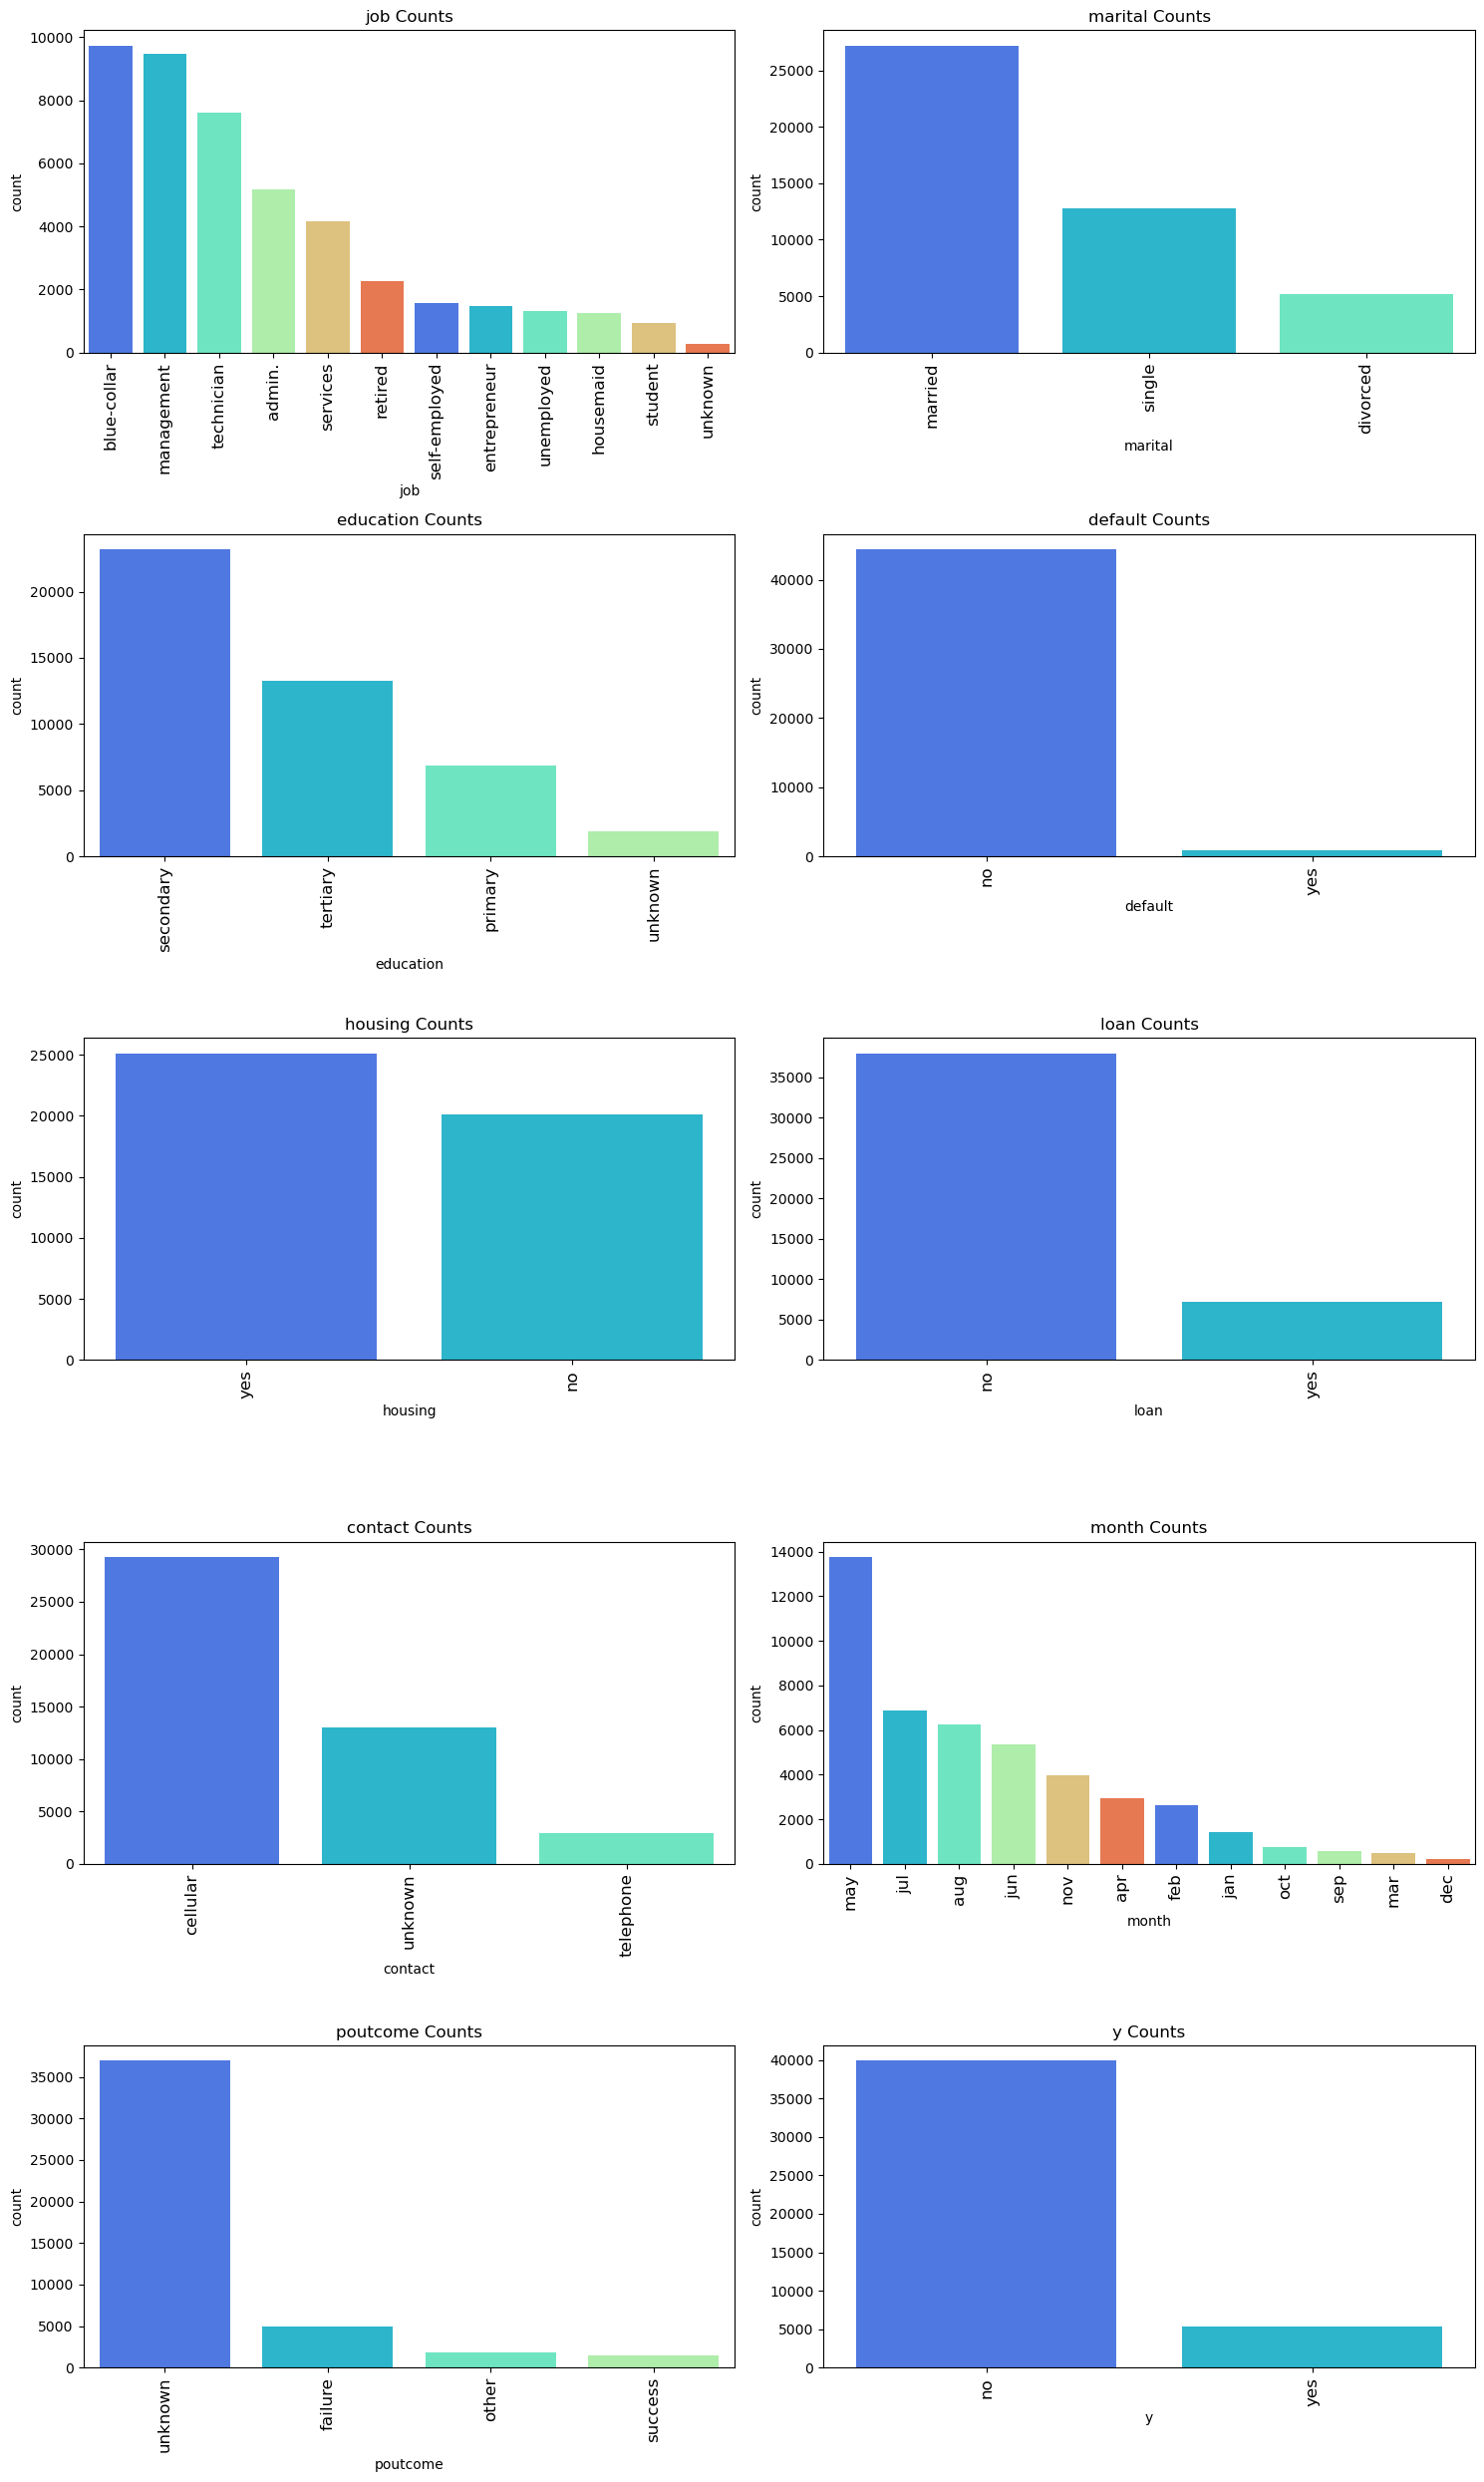

In [7]:
num_columns = len(categorical_data.columns)
num_rows = num_columns // 2 + num_columns % 2  # Ensure odd number of columns works correctly
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, num_rows * 5))

pal = sns.color_palette('rainbow')
for i, column in enumerate(categorical_data.columns):
    row_index = i // 2
    col_index = i % 2
    
    sns.countplot(x=column, data=categorical_data, palette=pal,
                  order=categorical_data[column].value_counts().index,
                  ax=axes[row_index, col_index])
    
    axes[row_index, col_index].set_xticklabels(axes[row_index, col_index].get_xticklabels(), rotation=90, fontsize=12)
    axes[row_index, col_index].set_title(f'{column} Counts')

# Adjust layout
plt.tight_layout()
plt.show()


### Labelencoder to convert categorical data into numeric


Label Encoding for job:
Value: management -> Label: 4 --> Counts: 9458
Value: technician -> Label: 9 --> Counts: 7597
Value: entrepreneur -> Label: 2 --> Counts: 1487
Value: blue-collar -> Label: 1 --> Counts: 9732
Value: unknown -> Label: 11 --> Counts: 288
Value: retired -> Label: 5 --> Counts: 2264
Value: admin. -> Label: 0 --> Counts: 5171
Value: services -> Label: 7 --> Counts: 4154
Value: self-employed -> Label: 6 --> Counts: 1579
Value: unemployed -> Label: 10 --> Counts: 1303
Value: housemaid -> Label: 3 --> Counts: 1240
Value: student -> Label: 8 --> Counts: 938

Label Encoding for marital:
Value: married -> Label: 1 --> Counts: 27214
Value: single -> Label: 2 --> Counts: 12790
Value: divorced -> Label: 0 --> Counts: 5207

Label Encoding for education:
Value: tertiary -> Label: 2 --> Counts: 13301
Value: secondary -> Label: 1 --> Counts: 23202
Value: unknown -> Label: 3 --> Counts: 1857
Value: primary -> Label: 0 --> Counts: 6851

Label Encoding for default:
Value: no -> Labe

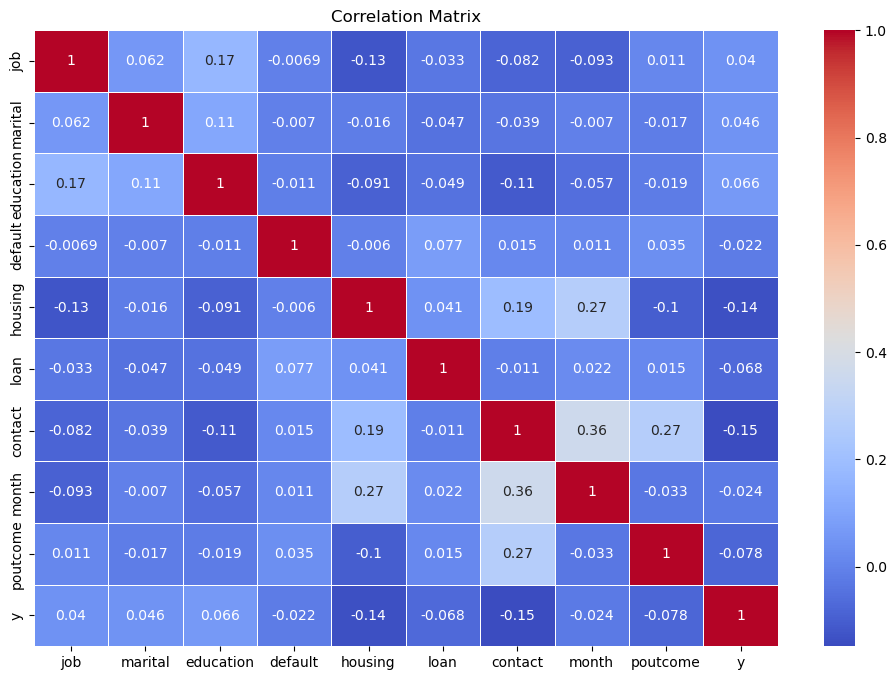

In [8]:
cat_data = categorical_data.copy()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_data.columns:
    cat_data[column] = label_encoder.fit_transform(cat_data[column])
    print(f"\nLabel Encoding for {column}:")
    # print("\n", cat_data[column].value_counts())
    unique_values = categorical_data[column].unique()

    for value in unique_values:
        label = label_encoder.transform([value])[0]
        counts = cat_data[column].value_counts()[label]
        print(f"Value: {value} -> Label: {label} --> Counts: {counts}")
    
# Correlation Plot
corr_matrix = cat_data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Note: housing , contact

## Numeric Data

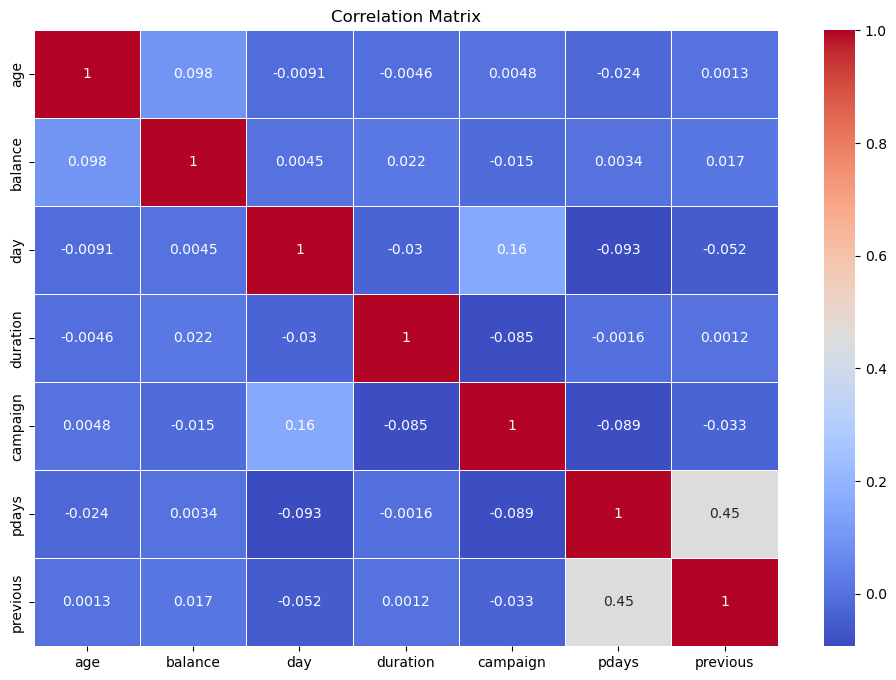

In [9]:
# Correlation Plot
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

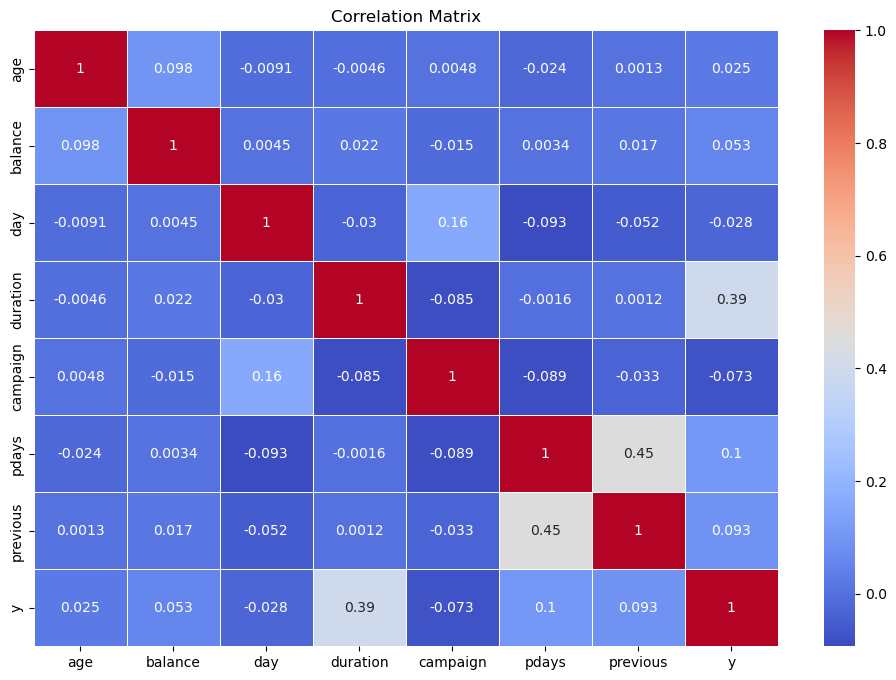

In [10]:
# Correlation Plot with dependent_variable
data_2 = pd.concat([numeric_data, cat_data['y']], axis=1)
corr_matrix = data_2.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Note:  duration, pdays                ------     housing , contact

### visualization

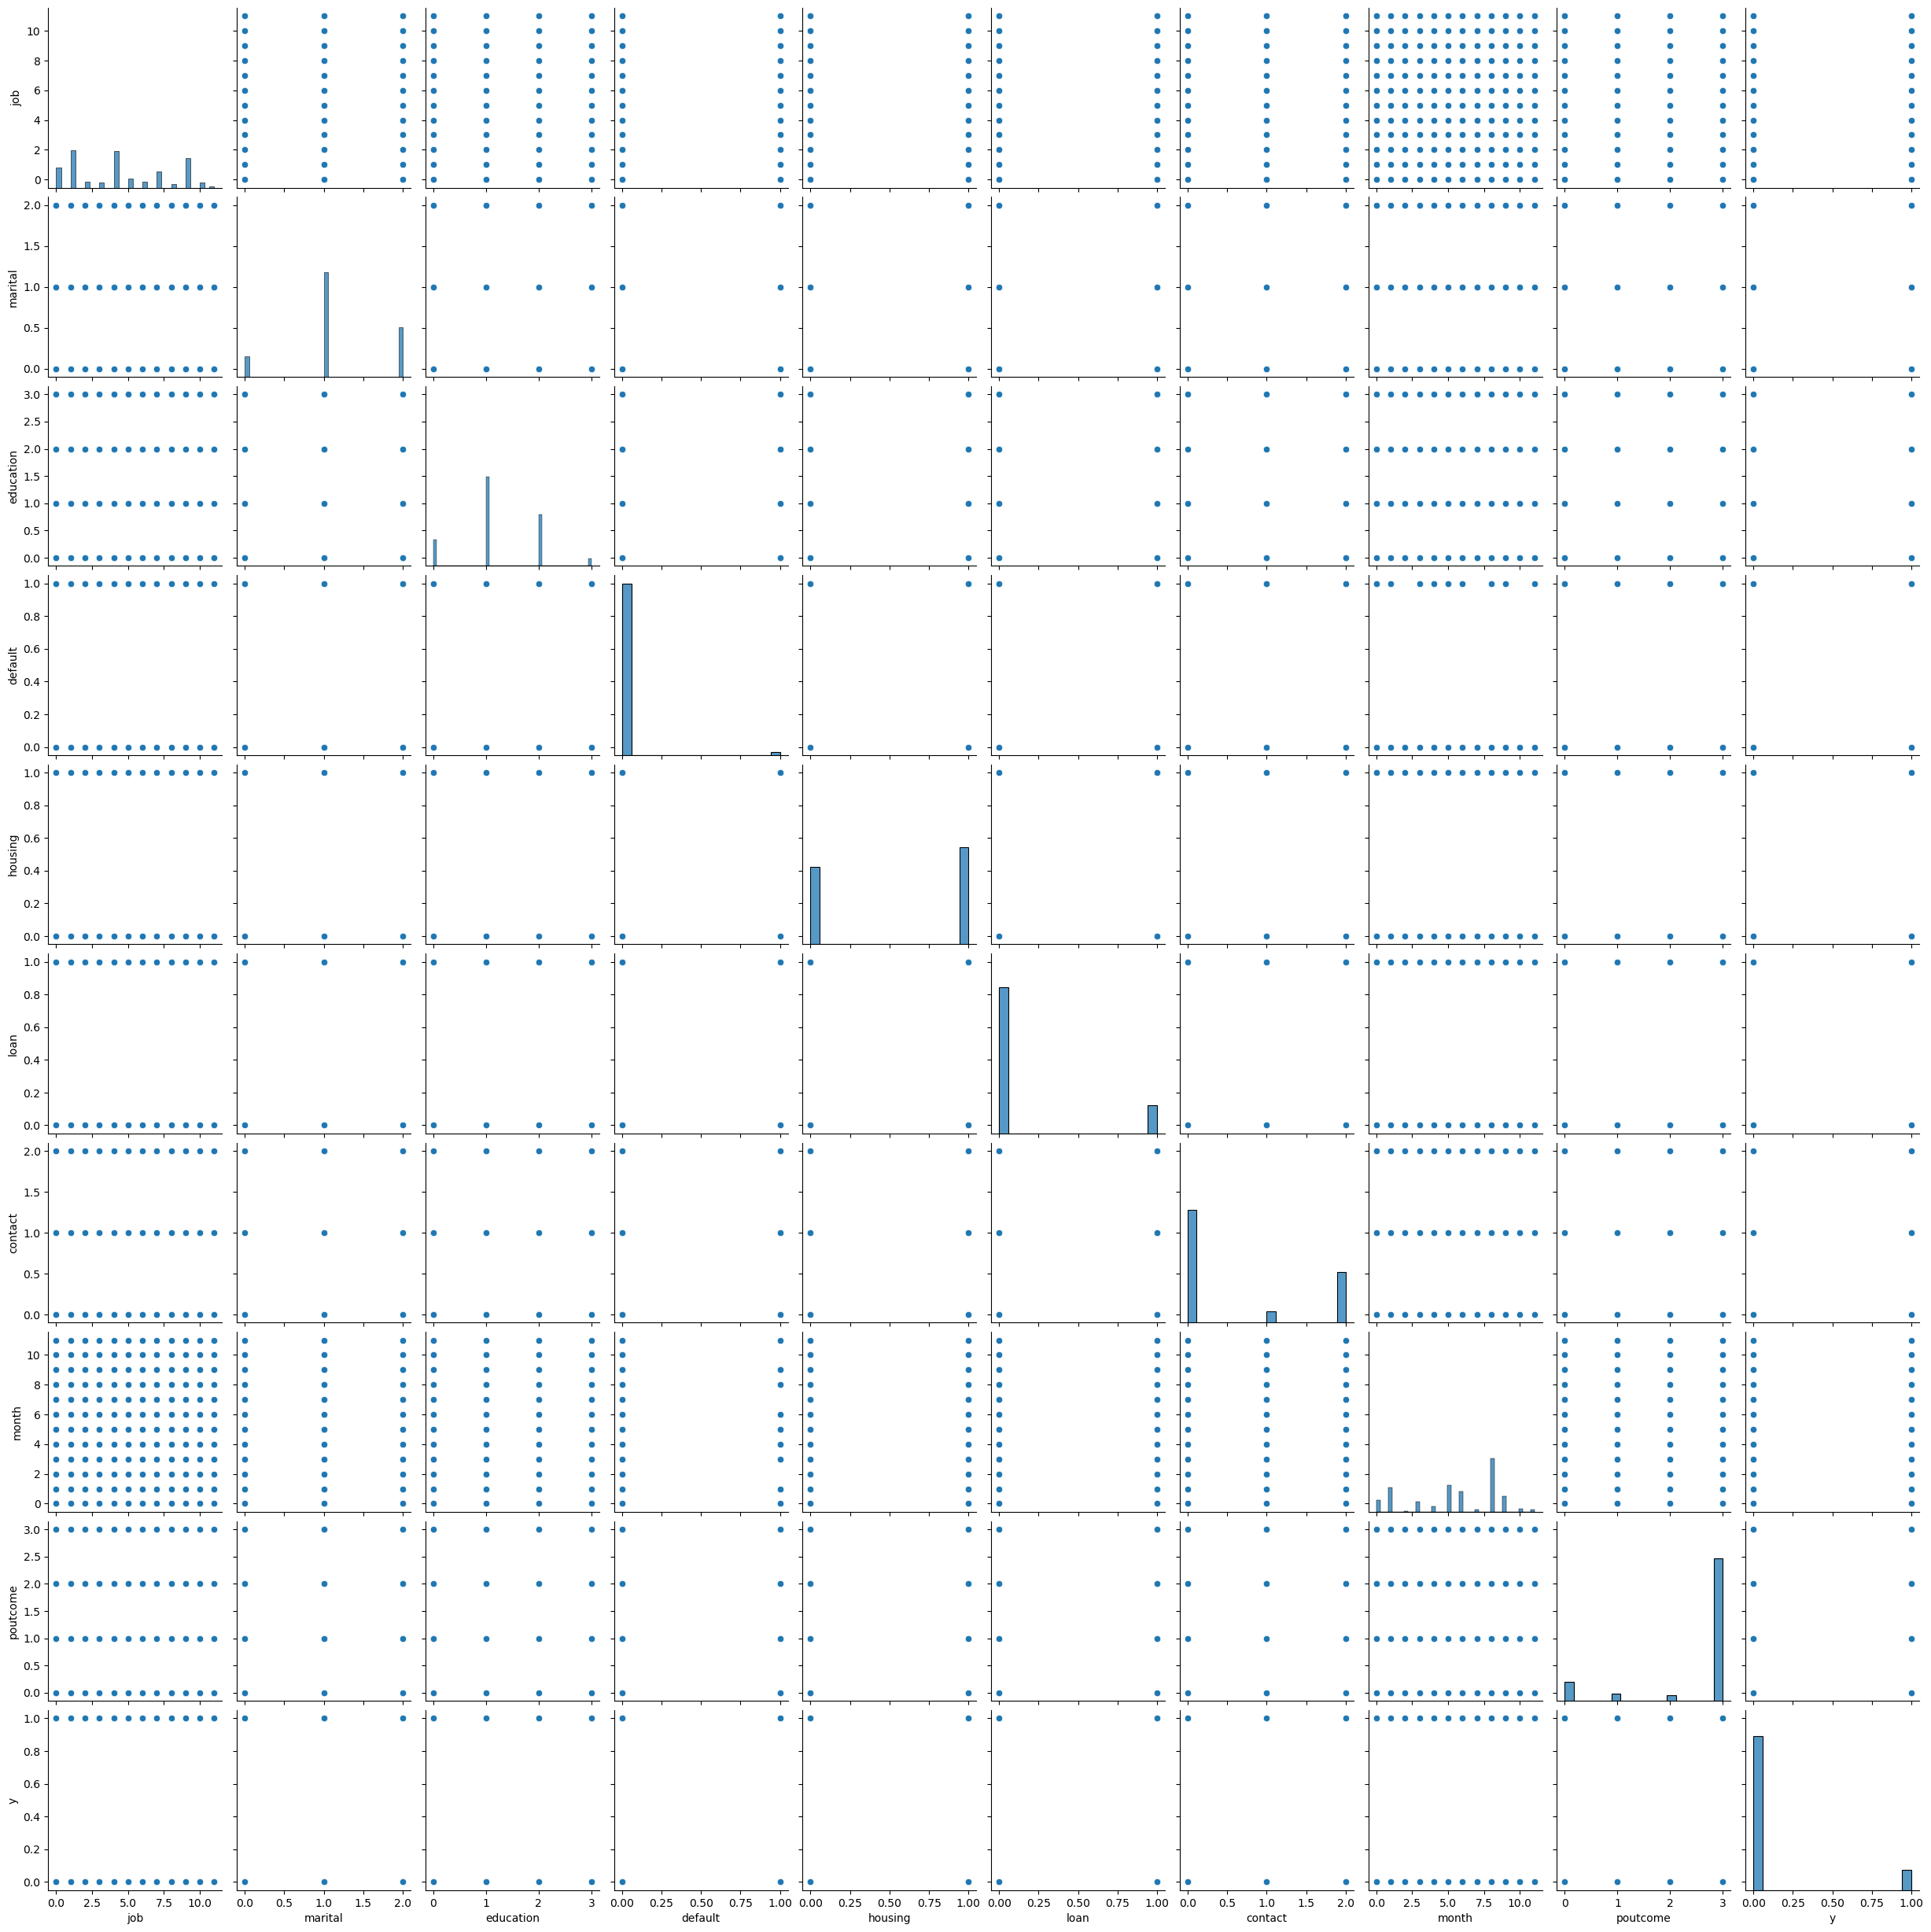

In [11]:
# relationship plot for categorical data
sns.pairplot(data= cat_data)
plt.show()

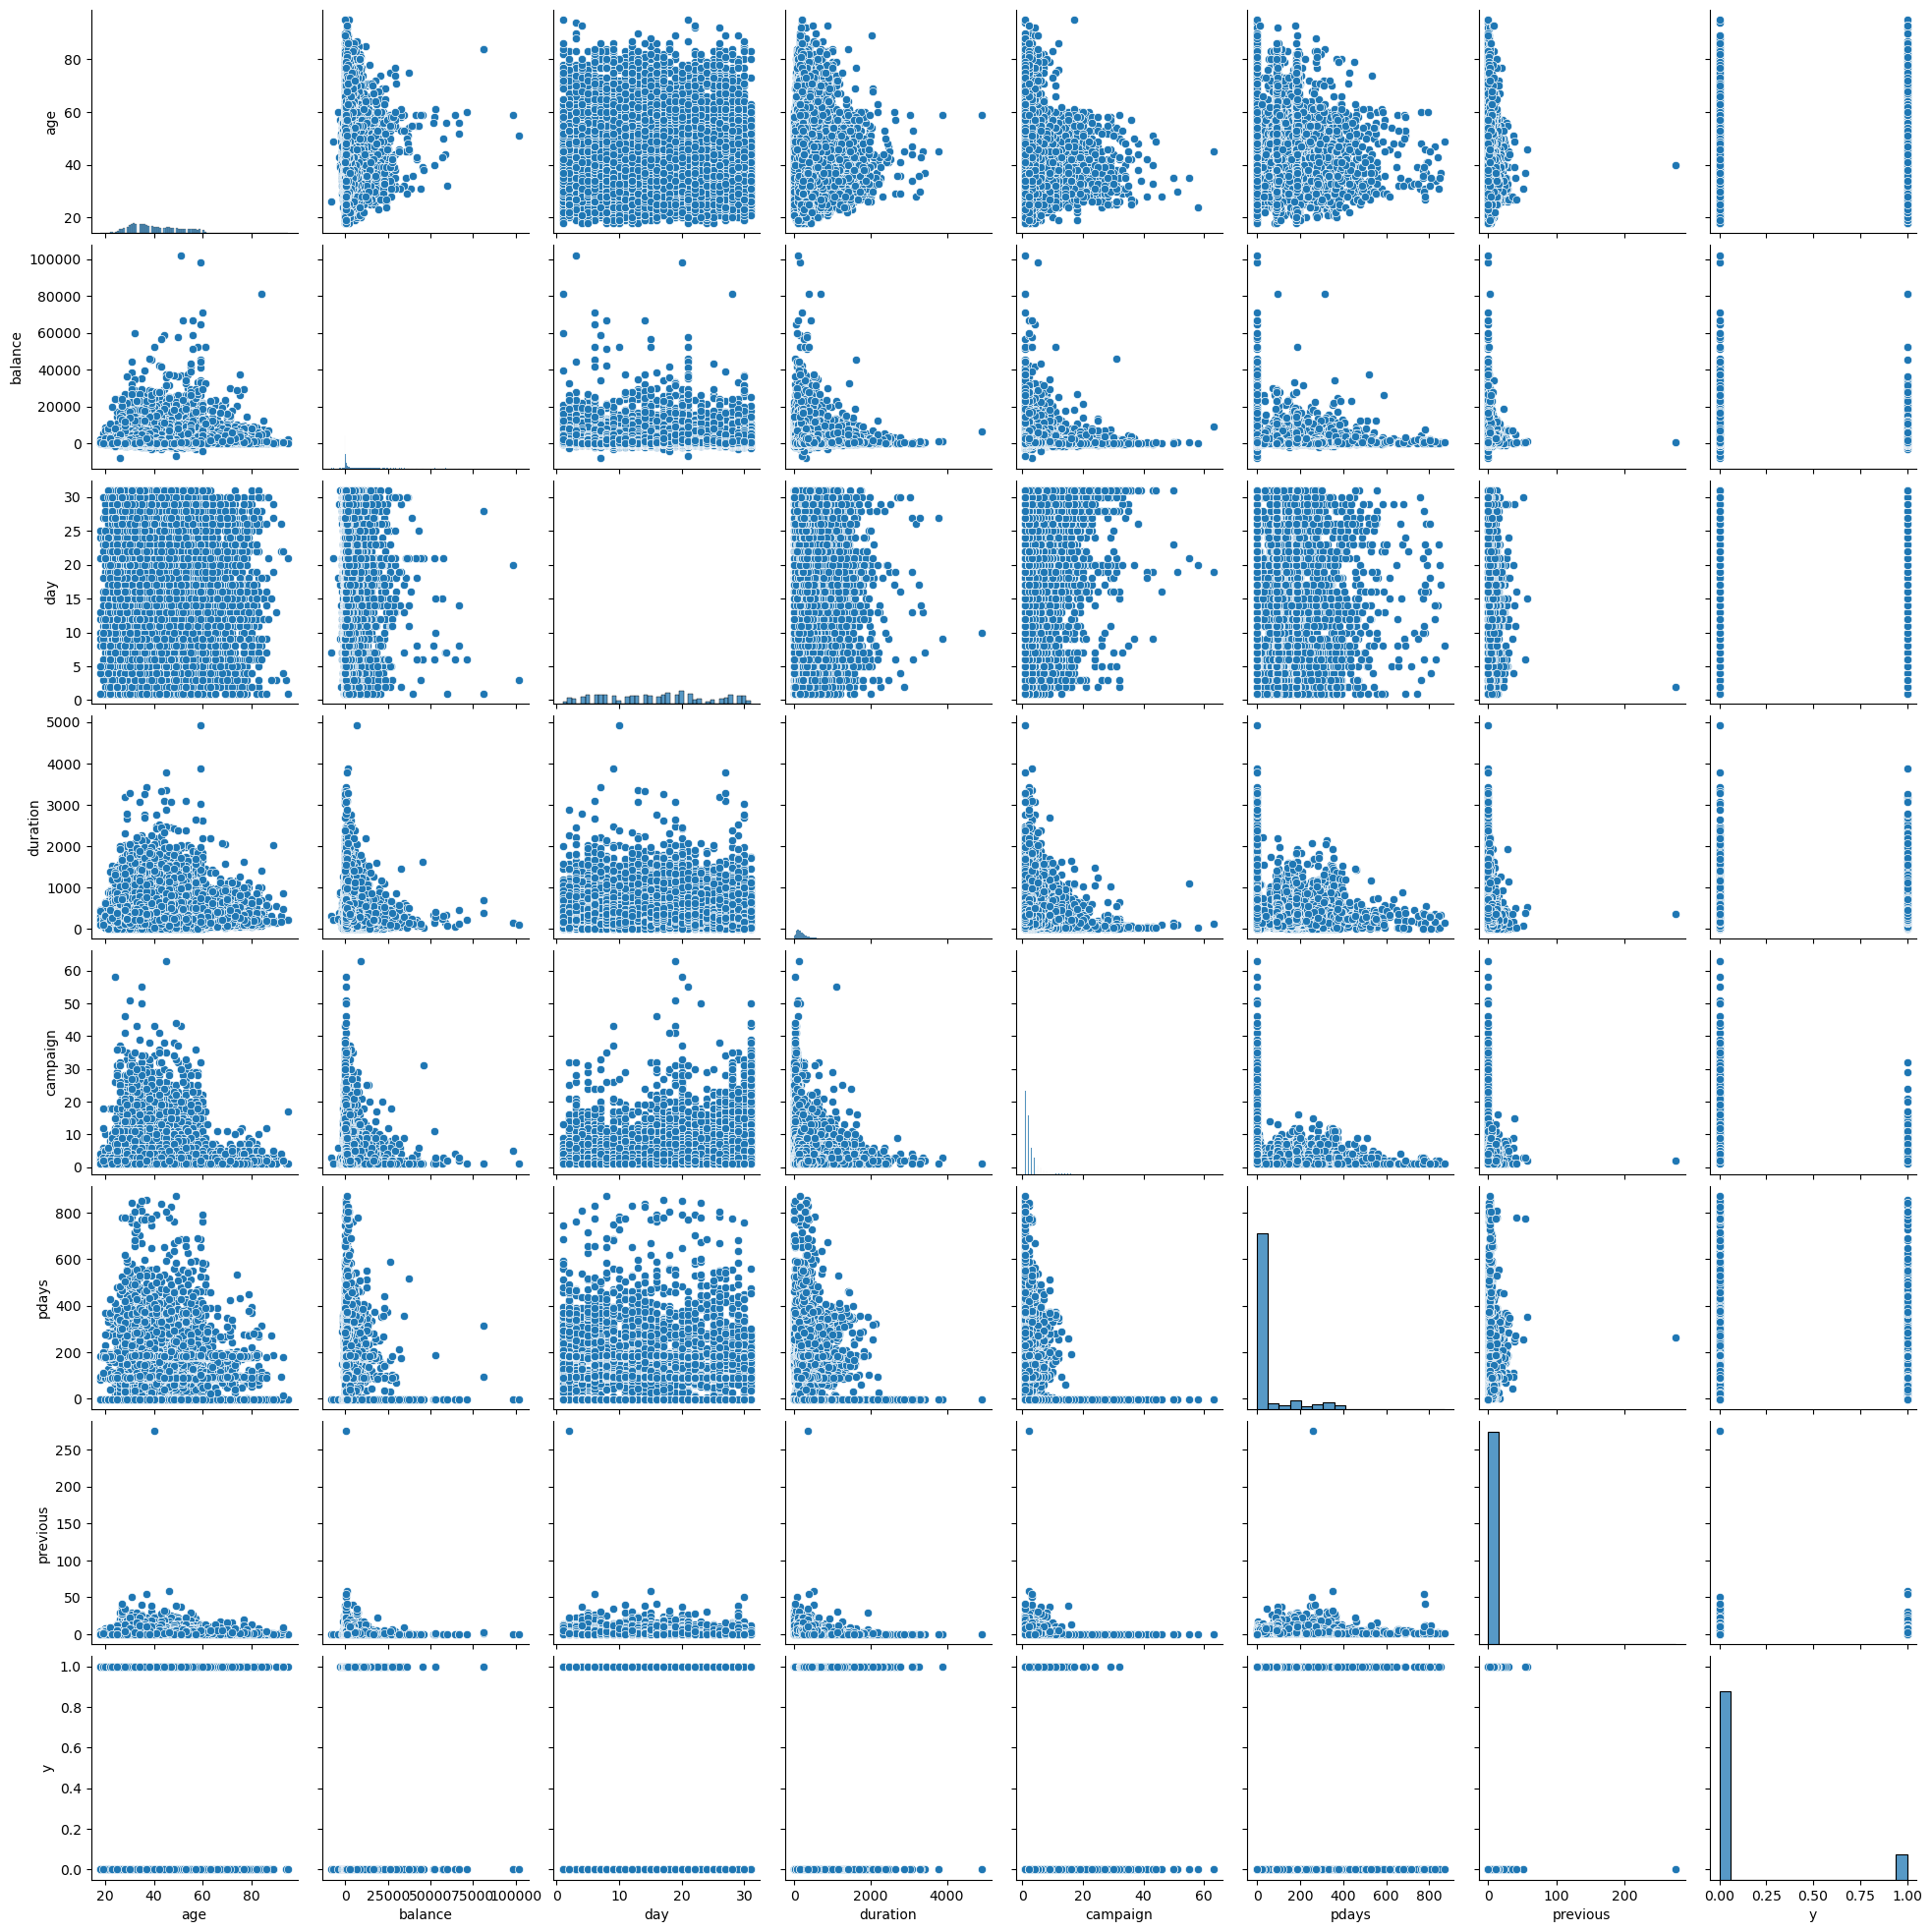

In [12]:
# relationship plot for numeric data
sns.pairplot(data= data_2)
plt.show()

### Detect outliers and handle them

In [13]:
data_filtered=pd.concat([numeric_data,cat_data],axis=1)    #,cat_data ,numeric_data, data_2
data_filtered.shape

(45211, 17)

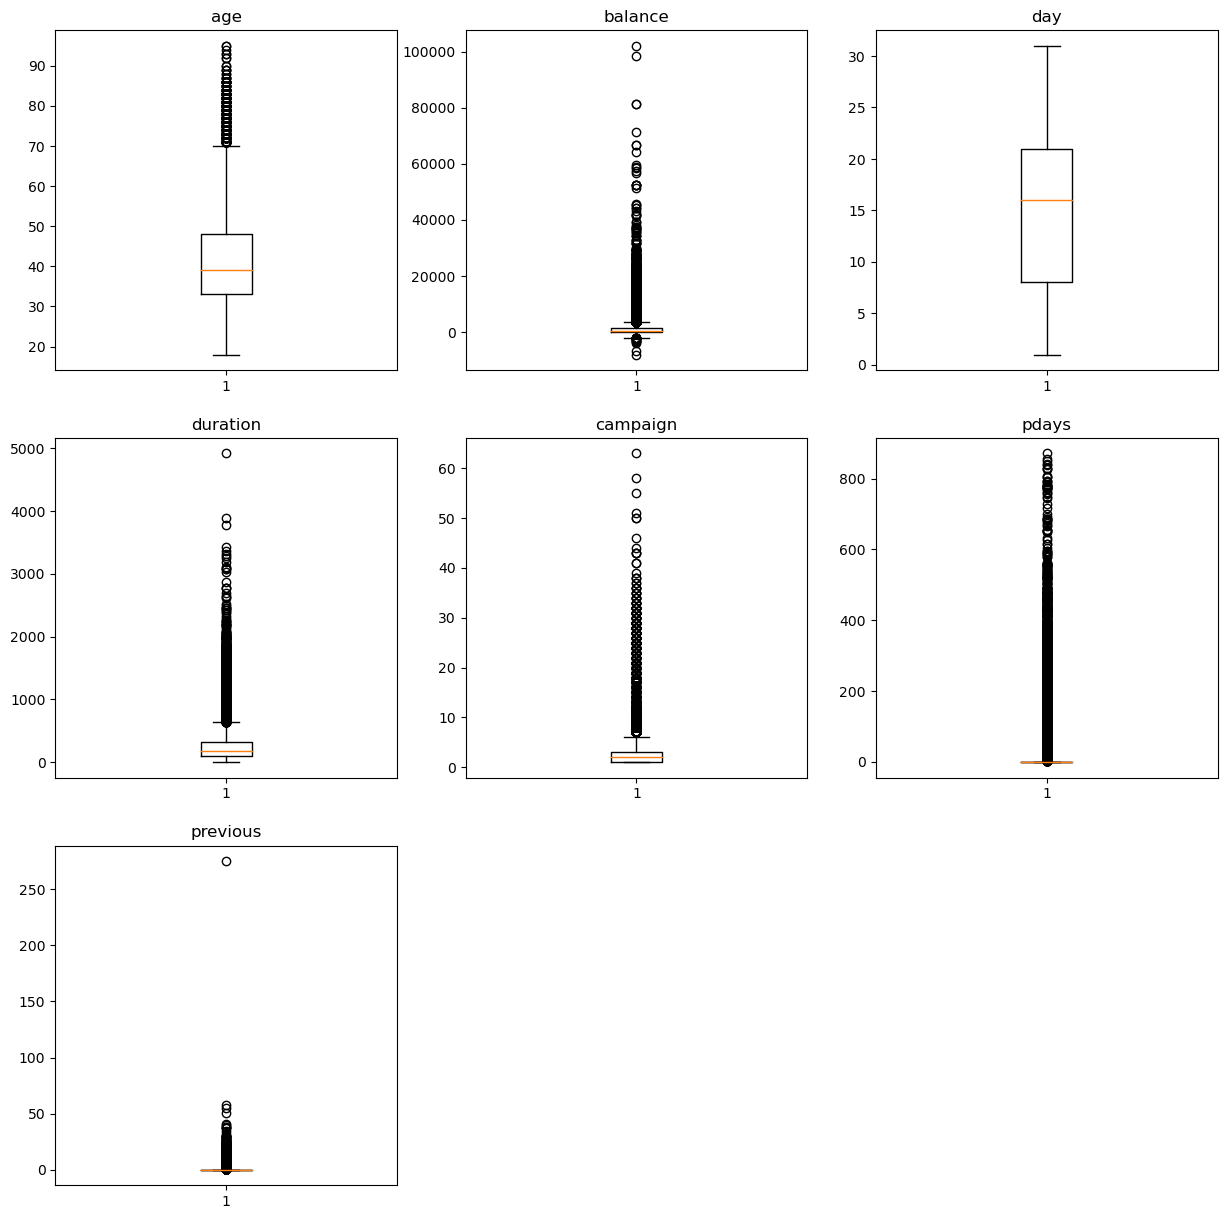

In [14]:
# display boxplots

num_columns = len(numeric_data.columns)
subplots_per_row = 3
num_rows = (num_columns + subplots_per_row - 1) // subplots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i in range(num_columns):
    ax = axes[i]
    ax.boxplot(data_filtered.iloc[:, i])
    ax.set_title(data_filtered.columns[i])

# Hide any remaining empty subplots
for i in range(num_columns, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


#### Treating outliers with IQR

In [15]:
num_columns = len(numeric_data.columns)
new_data = data_filtered.copy()

for i in range(num_columns):
    # print("\n\nColumn Name:",(data_filtered.columns[i]))
    print("\n\nColumn Name: \033[1;34m" + "\033[1m" + data_filtered.columns[i] + "\033[0m")

    # Calculate the IQR
    Q1 = data_filtered.iloc[:, i].quantile(0.25)
    Q3 = data_filtered.iloc[:, i].quantile(0.75)
    IQR = Q3 - Q1
        
    # Identify and mark outliers using IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(data_filtered[(data_filtered.iloc[:, i] > upper_bound) | (data_filtered.iloc[:, i] < lower_bound)].tail(2))
    
    # # Changing the outliers
    # new_data.loc[(new_data[data_filtered.columns[i]] > upper_bound), data_filtered.columns[i]] = upper_bound
    # new_data.loc[(new_data[data_filtered.columns[i]] < lower_bound), data_filtered.columns[i]] = lower_bound
    
    # # Drop rows with outliers
    # outliers = new_data[(new_data.iloc[:, i] < lower_bound) | (new_data.iloc[:, i] > upper_bound)].index   
    # new_data = new_data.drop(outliers)
    
print("\nShape of new data:",new_data.shape)
# sns.boxplot(data = new_data)
# plt.show()




Column Name: age
       age  balance  day  duration  campaign  pdays  previous  job  marital  \
45207   71     1729   17       456         2     -1         0    5        0   
45208   72     5715   17      1127         5    184         3    5        1   

       education  default  housing  loan  contact  month  poutcome  y  
45207          0        0        0     0        0      9         3  1  
45208          1        0        0     0        0      9         2  1  


Column Name: balance
       age  balance  day  duration  campaign  pdays  previous  job  marital  \
45191   75     3810   16       262         1    183         1    5        0   
45208   72     5715   17      1127         5    184         3    5        1   

       education  default  housing  loan  contact  month  poutcome  y  
45191          2        0        1     0        0      9         0  1  
45208          1        0        0     0        0      9         2  1  


Column Name: day
Empty DataFrame
Columns: [age, 

Note: not removing outliers, 'yes' y output values getting less

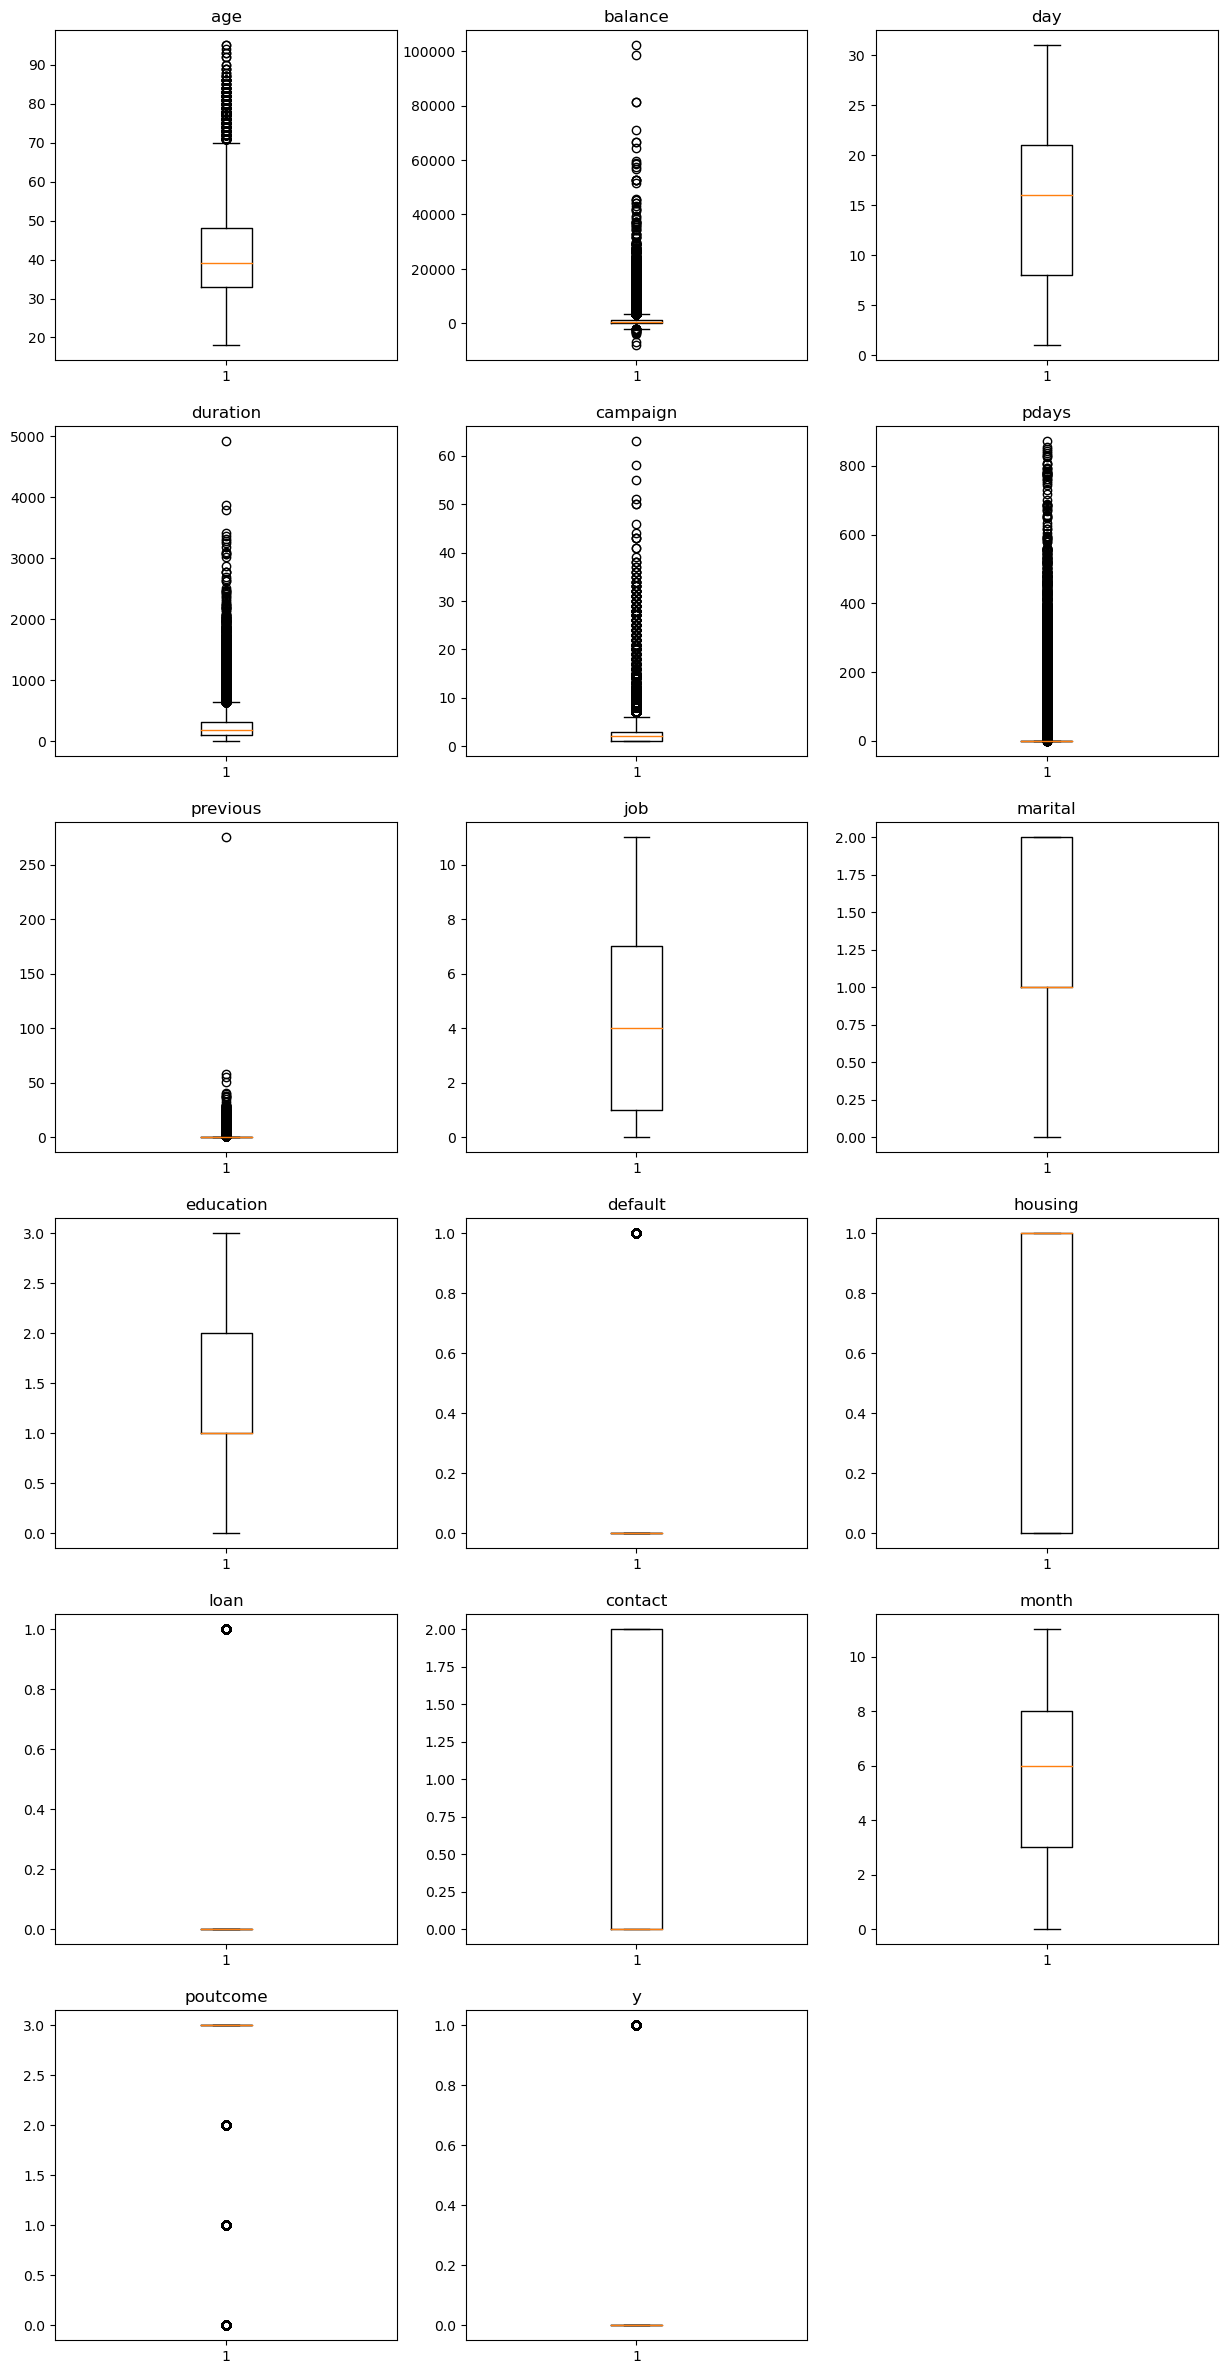

In [16]:
# display boxplots of Treated outliers with IQR

num_columns = len(new_data.columns)
subplots_per_row = 3
num_rows = (num_columns + subplots_per_row - 1) // subplots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 5*num_rows))
axes = axes.flatten()

for i in range(num_columns):
    ax = axes[i]
    ax.boxplot(new_data.iloc[:, i])
    ax.set_title(new_data.columns[i])

# Hide any remaining empty subplots
for i in range(num_columns, num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


In [17]:
# # relationship plot for all data
# sns.pairplot(data= new_data)
# plt.show()

In [18]:
# to check repeatation iteration
# data_filtered=new_data

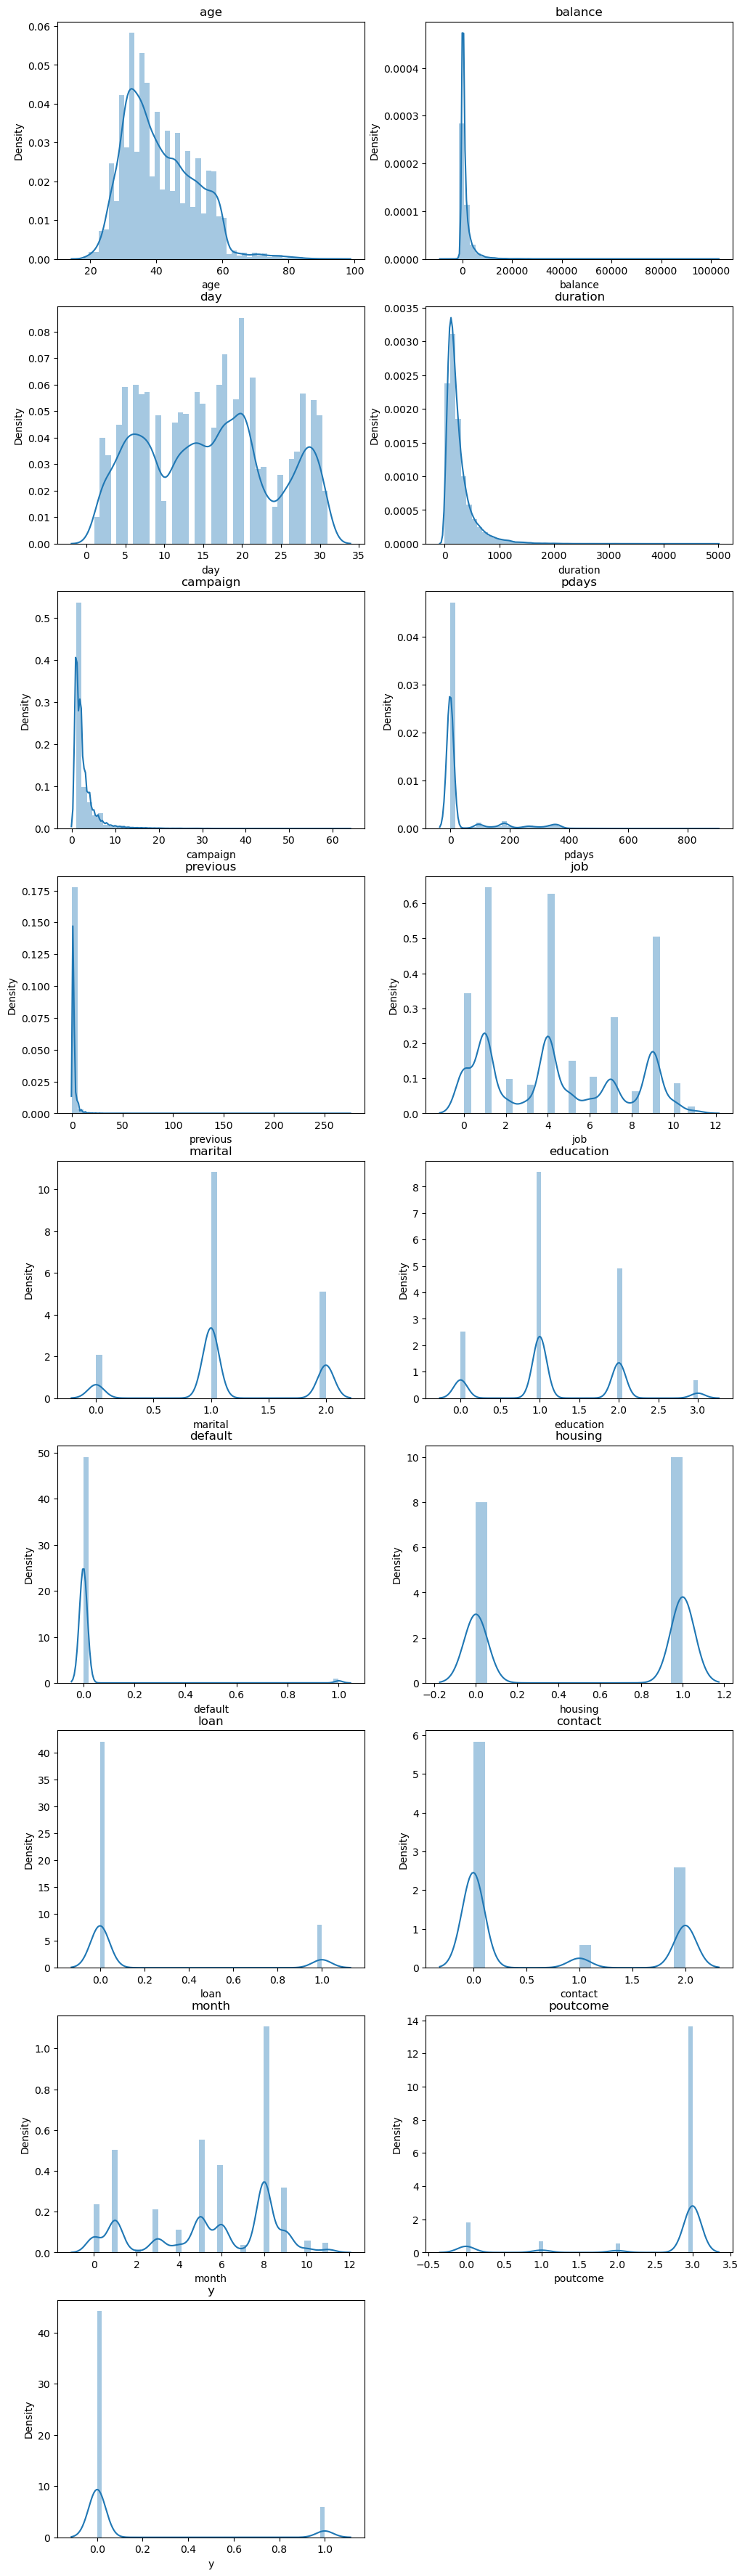

In [19]:
# distribution plots
subplots_per_row = 2
num_rows = (len(new_data.columns) + subplots_per_row - 1) // subplots_per_row
fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(12, 5*num_rows))
axes = axes.flatten()

for i, column in enumerate(new_data.columns):
    ax = axes[i]
    sns.distplot(new_data[column], kde=True, ax=ax)
    ax.set_title(column)
    
# Hide any remaining empty subplots
for i in range(len(new_data.columns), num_rows * subplots_per_row):
    fig.delaxes(axes[i])

# plt.tight_layout()
plt.show()


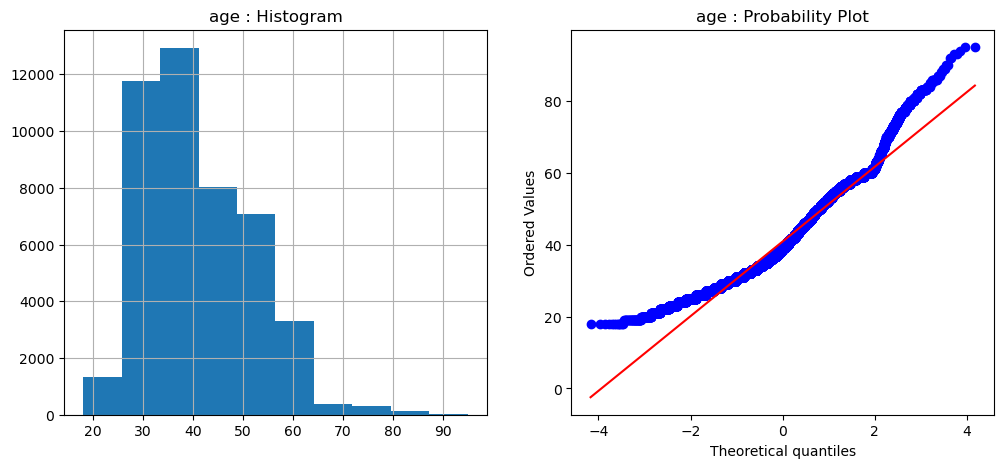

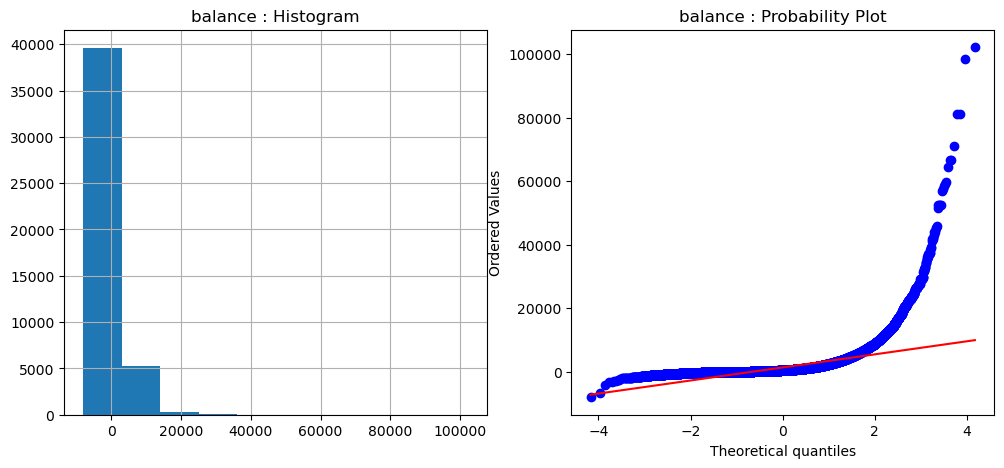

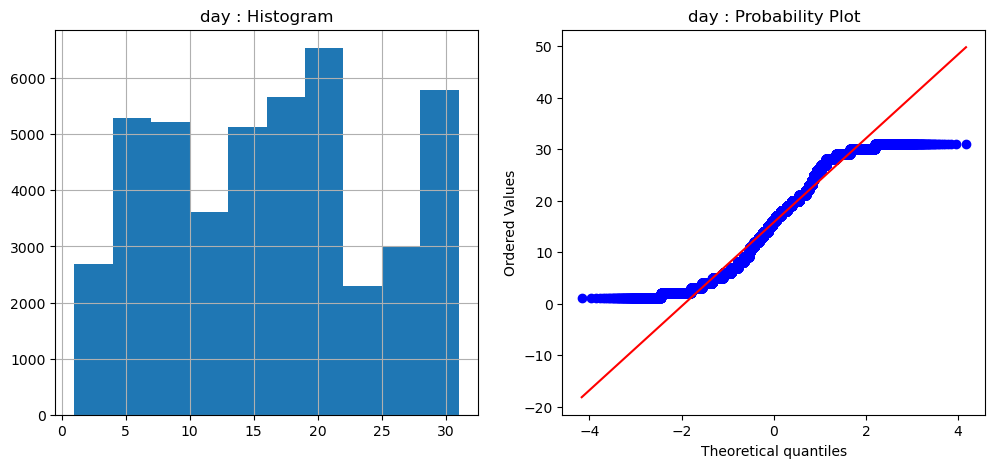

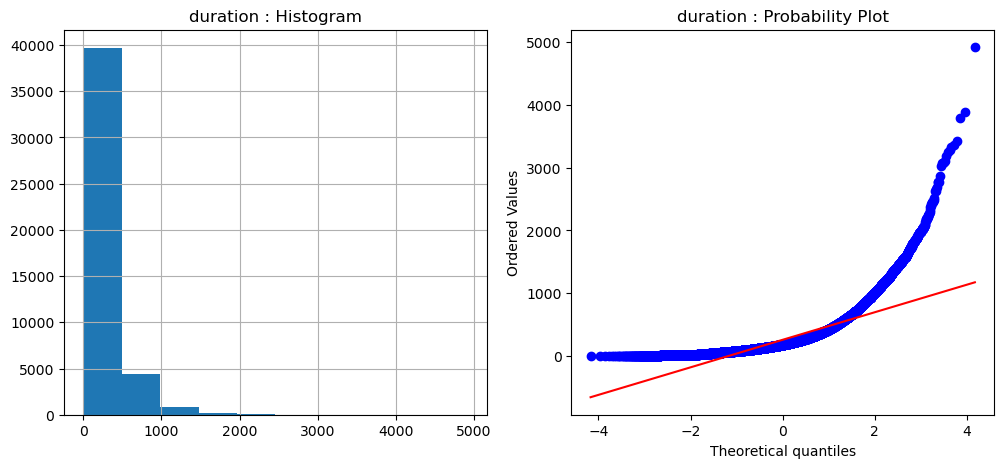

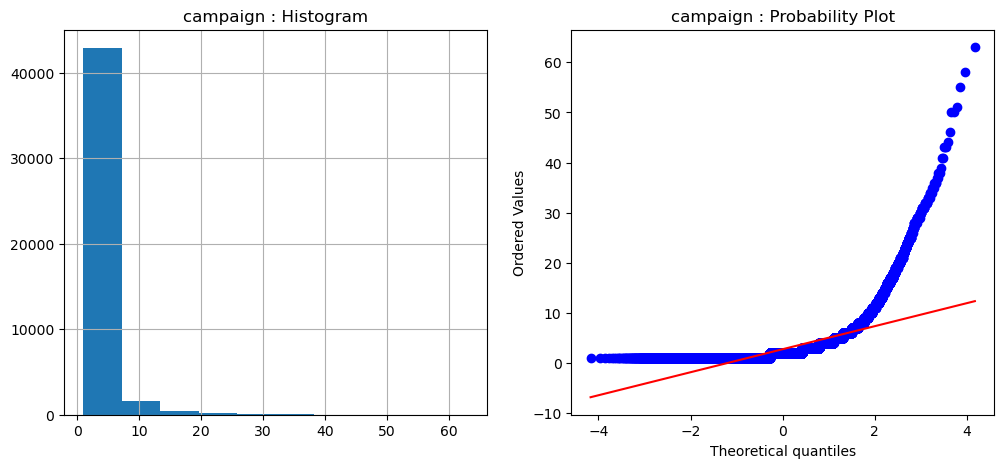

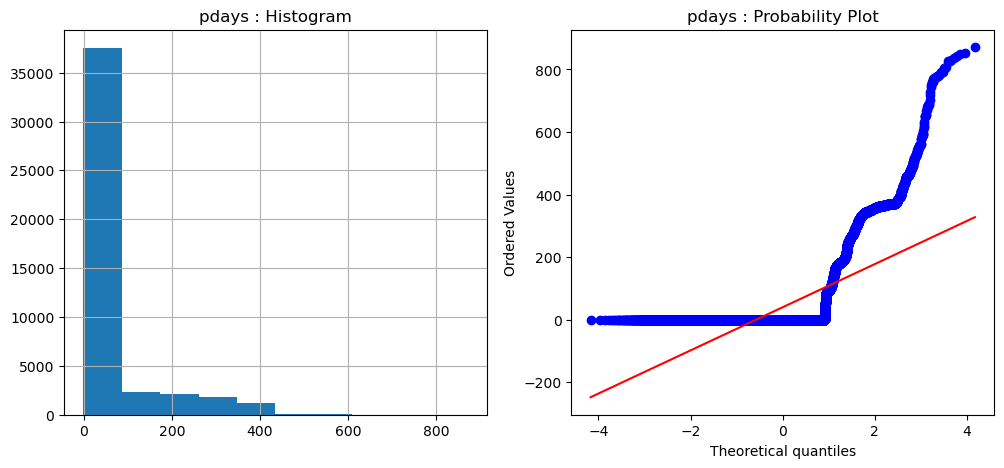

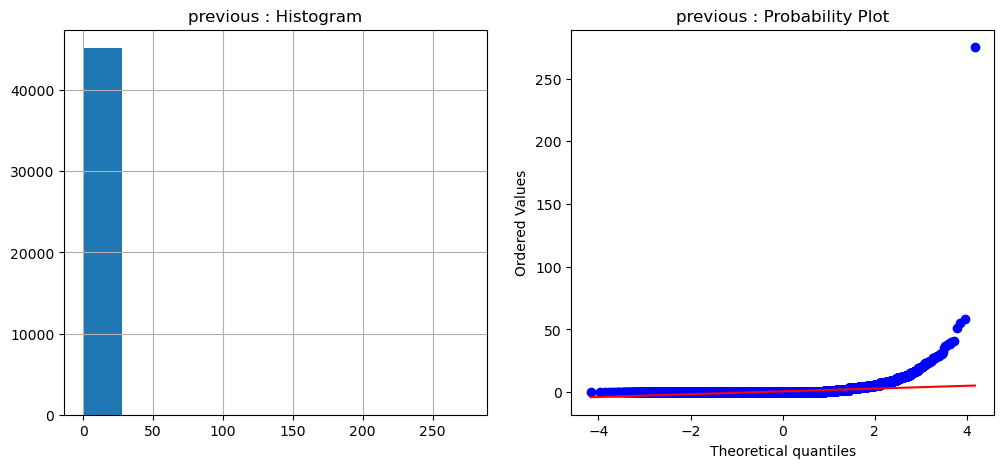

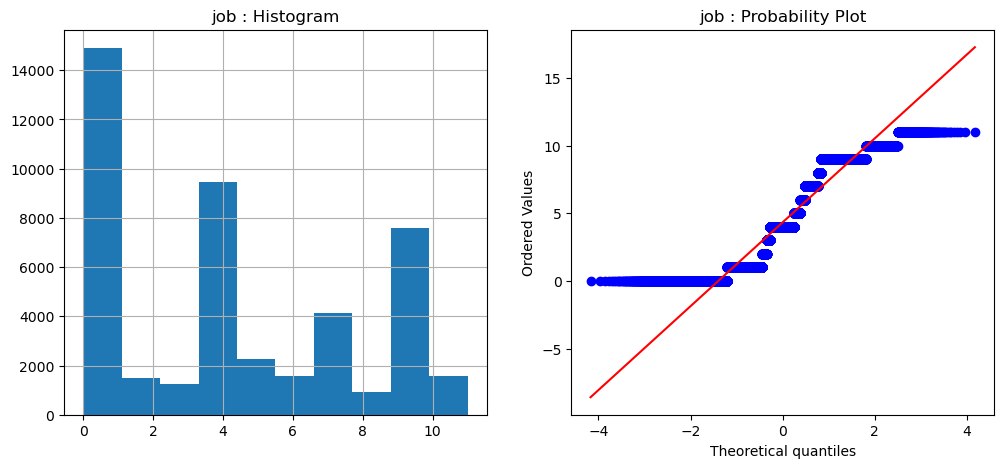

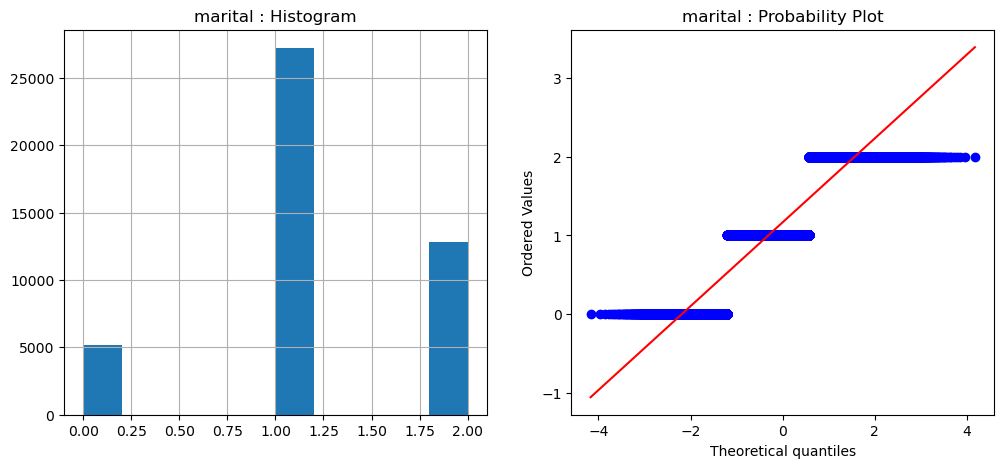

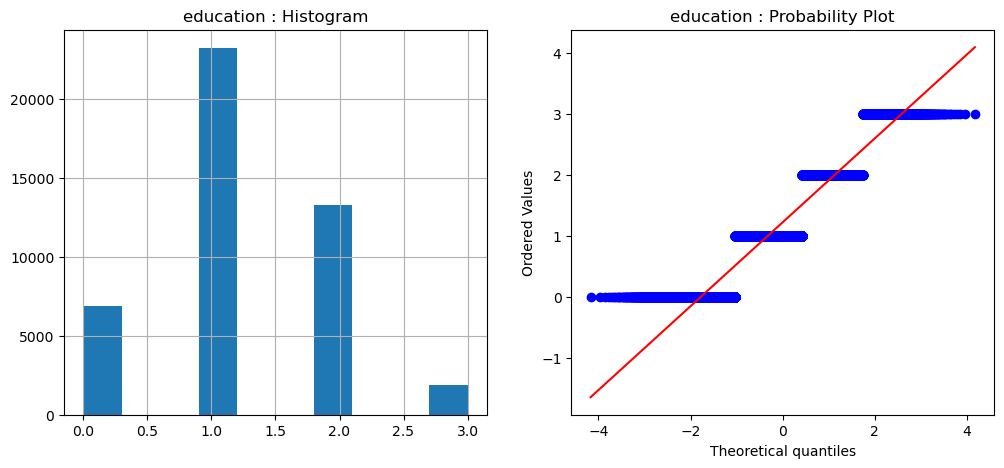

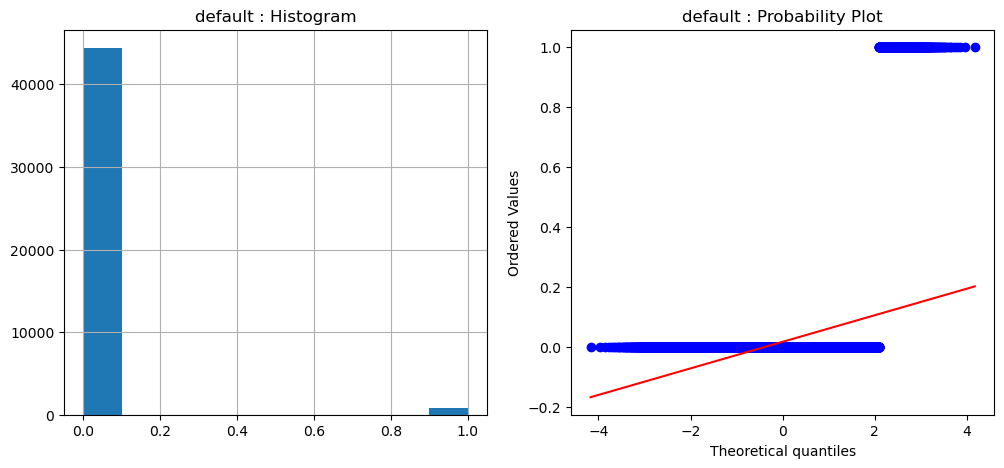

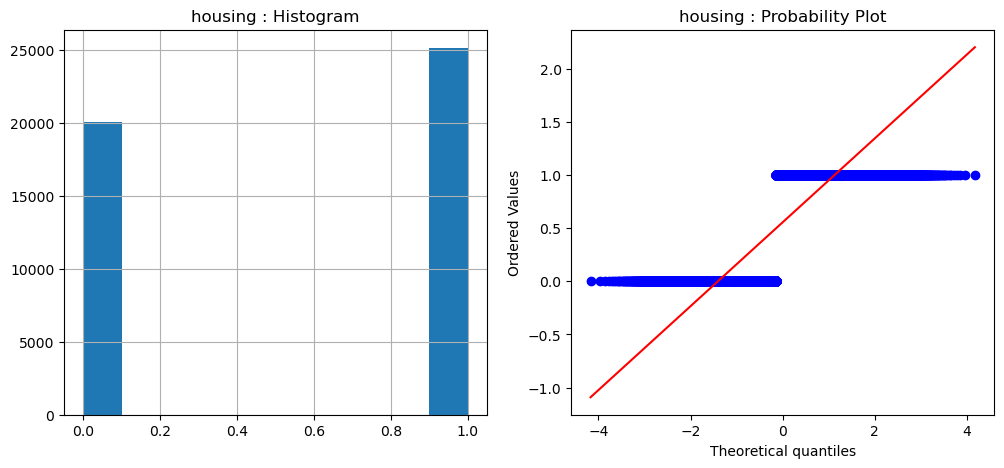

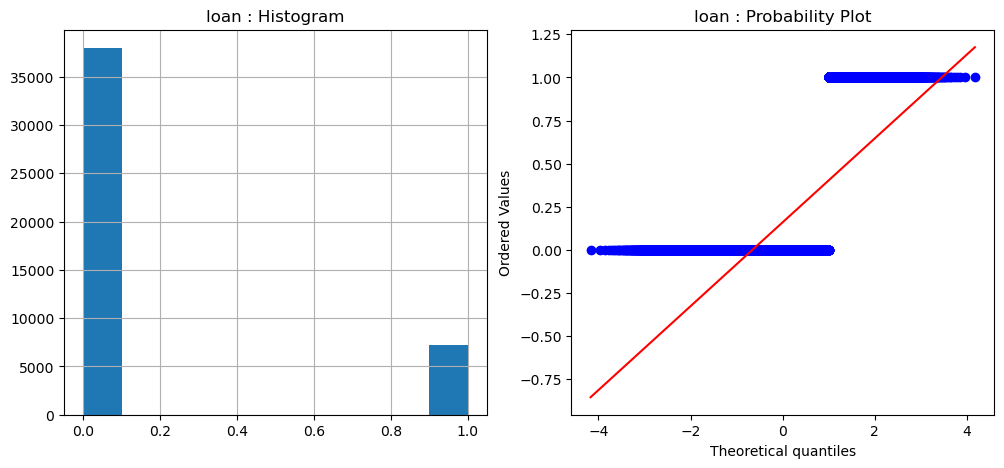

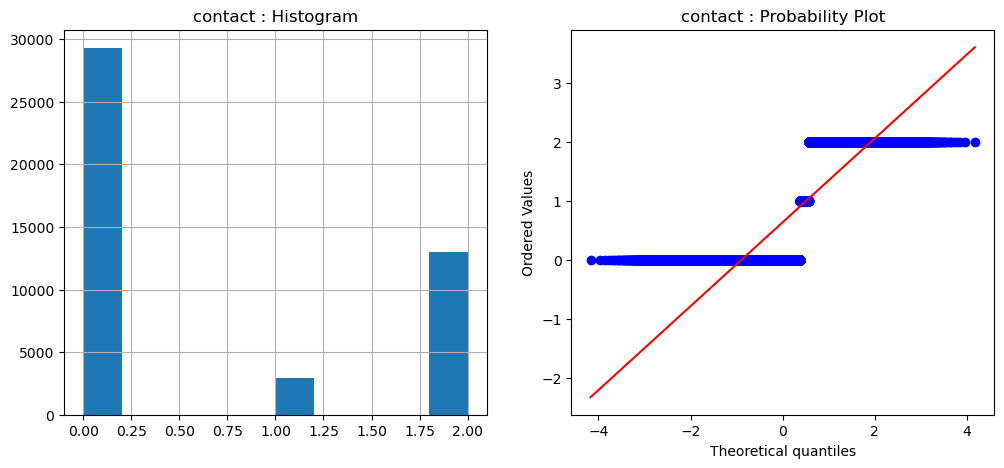

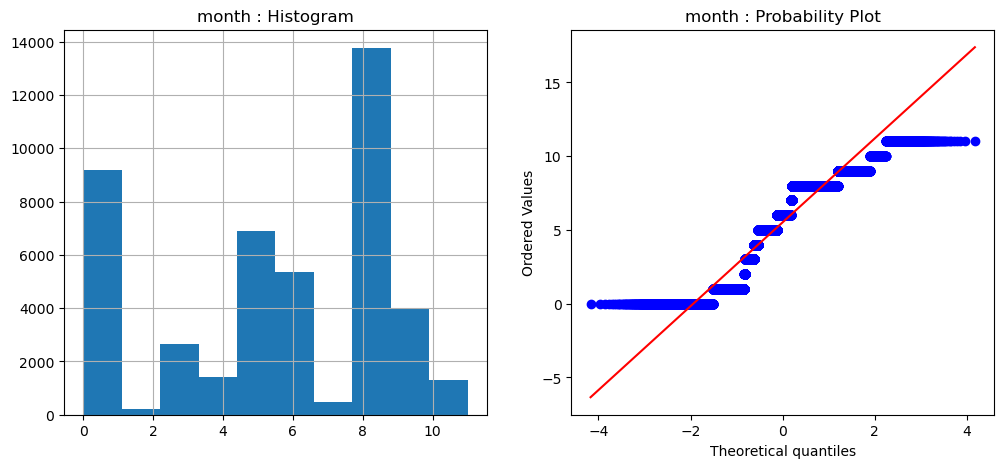

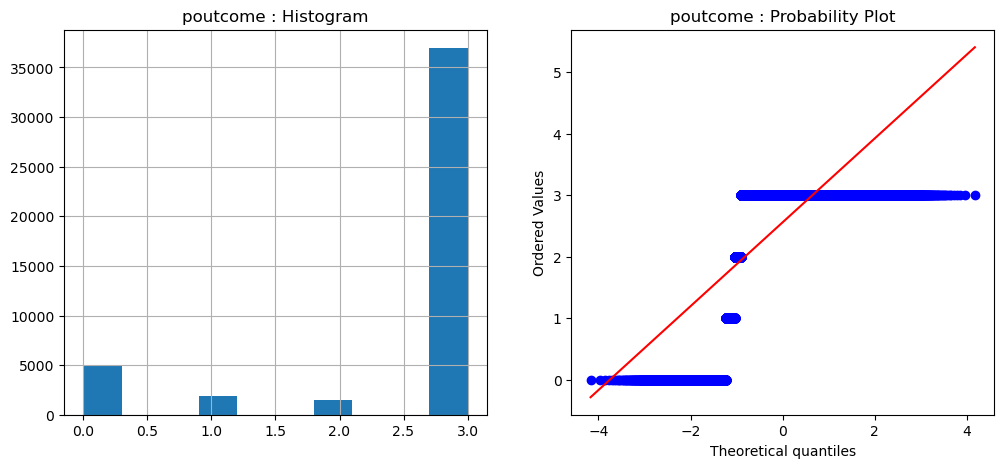

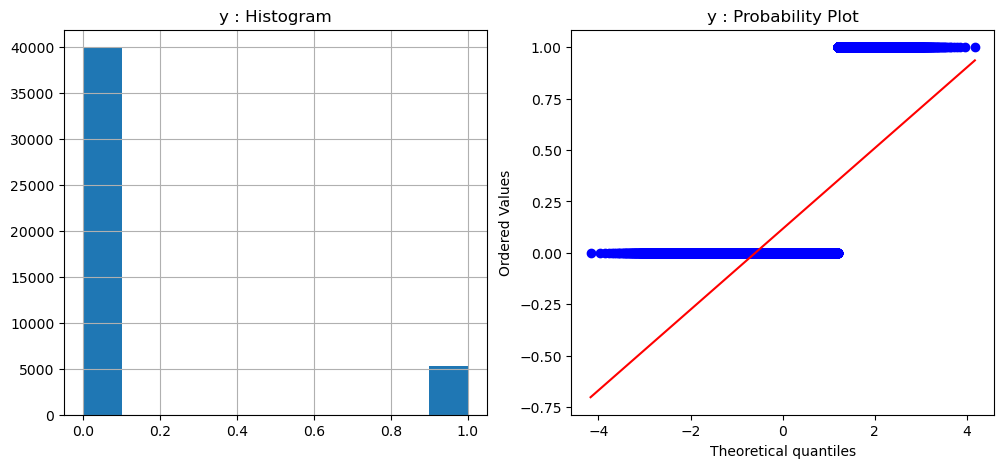

In [20]:
# Histogram & Probability Plot (Q-Q plot)
import pylab
import scipy.stats as stat

def plot_data(df, feature):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.title(f'{feature} : Histogram')
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.title(f'{feature} : Probability Plot')

# Iterate through all columns
for column in new_data.columns:
    plot_data(new_data, column)
    plt.show()


### Feature scaling

In [21]:
# from sklearn.preprocessing import StandardScaler
# std1 = StandardScaler()
# std2 = StandardScaler()
# new_data_norm=new_data.copy()
# new_data_norm.iloc[:,1:]= std1.fit_transform(new_data.iloc[:,1:].values)
# new_data_norm.iloc[:,0] = std2.fit_transform(new_data.iloc[:,0].values.reshape(-1, 1))   #Scaling output data also
# # print(new_data_norm.head())
# new_data_norm.tail()

# Model Building  & Testing

In [22]:
X=new_data.iloc[:,:-1]
y=new_data.iloc[:,-1]
X_train = X
X_test = X
y_train= y
y_test = y 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### finding best correlation condition and features

In [23]:
# finding best corr condition 
dependent_variable='y'
corr_matrix = new_data.corr(numeric_only=True)
significant_correlations1 = corr_matrix[abs(corr_matrix[dependent_variable]) >= 0.24][[dependent_variable]]  
significant_variables1 = significant_correlations1.index.tolist()
print(significant_variables1)

data_signf=new_data[significant_variables1]
regression_model = LogisticRegression()
X=data_signf.iloc[:,:-1]
y=data_signf.iloc[:,-1]
regression_model.fit(X = X, y = y)
score=regression_model.score(X = X, y = y)
print("score:",score)
new_data.corr()

['duration', 'y']
score: 0.8886111786954503


age   balance       day  duration  campaign     pdays  \
age        1.000000  0.097783 -0.009120 -0.004648  0.004760 -0.023758   
balance    0.097783  1.000000  0.004503  0.021560 -0.014578  0.003435   
day       -0.009120  0.004503  1.000000 -0.030206  0.162490 -0.093044   
duration  -0.004648  0.021560 -0.030206  1.000000 -0.084570 -0.001565   
campaign   0.004760 -0.014578  0.162490 -0.084570  1.000000 -0.088628   
pdays     -0.023758  0.003435 -0.093044 -0.001565 -0.088628  1.000000   
previous   0.001288  0.016674 -0.051710  0.001203 -0.032855  0.454820   
job       -0.021868  0.018232  0.022856  0.004744  0.006839 -0.024455   
marital   -0.403240  0.002122 -0.005261  0.011852 -0.008994  0.019172   
education -0.106807  0.064514  0.022671  0.001935  0.006255  0.000052   
default   -0.017879 -0.066745  0.009424 -0.010021  0.016822 -0.029979   
housing   -0.185513 -0.068768 -0.027982  0.005075 -0.023599  0.124178   
loan      -0.015655 -0.084350  0.011370 -0.012412  0.009980 -0.022754   
contact    0.026221 -0.027273 -0.027936 -0.020839  0.019614 -0.244816   
month     -0.042357  0.019777 -0.006028  0.006314 -0.110031  0.033065   
poutcome   0.007367 -0.020967  0.083460  0.010925  0.101588 -0.858362   
y          0.025155  0.052838 -0.028348  0.394521 -0.073172  0.103621   

           previous       job   marital  education   default   housing  \
age        0.001288 -0.021868 -0.403240  -0.106807 -0.017879 -0.185513   
balance    0.016674  0.018232  0.002122   0.064514 -0.066745 -0.068768   
day       -0.051710  0.022856 -0.005261   0.022671  0.009424 -0.027982   
duration   0.001203  0.004744  0.011852   0.001935 -0.010021  0.005075   
campaign  -0.032855  0.006839 -0.008994   0.006255  0.016822 -0.023599   
pdays      0.454820 -0.024455  0.019172   0.000052 -0.029979  0.124178   
previous   1.000000 -0.000911  0.014973   0.017570 -0.018329  0.037076   
job       -0.000911  1.000000  0.062045   0.166707 -0.006853 -0.125363   
marital    0.014973  0.062045  1.000000   0.108576 -0.007023 -0.016096   
education  0.017570  0.166707  0.108576   1.000000 -0.010718 -0.090790   
default   -0.018329 -0.006853 -0.007023  -0.010718  1.000000 -0.006025   
housing    0.037076 -0.125363 -0.016096  -0.090790 -0.006025  1.000000   
loan      -0.011043 -0.033004 -0.046893  -0.048574  0.077234  0.041323   
contact   -0.147811 -0.082063 -0.039201  -0.110928  0.015404  0.188123   
month      0.022727 -0.092870 -0.006991  -0.057304  0.011486  0.271481   
poutcome  -0.489752  0.011010 -0.016850  -0.019361  0.034898 -0.099971   
y          0.093236  0.040438  0.045588   0.066241 -0.022419 -0.139173   

               loan   contact     month  poutcome         y  
age       -0.015655  0.026221 -0.042357  0.007367  0.025155  
balance   -0.084350 -0.027273  0.019777 -0.020967  0.052838  
day        0.011370 -0.027936 -0.006028  0.083460 -0.028348  
duration  -0.012412 -0.020839  0.006314  0.010925  0.394521  
campaign   0.009980  0.019614 -0.110031  0.101588 -0.073172  
pdays     -0.022754 -0.244816  0.033065 -0.858362  0.103621  
previous  -0.011043 -0.147811  0.022727 -0.489752  0.093236  
job       -0.033004 -0.082063 -0.092870  0.011010  0.040438  
marital   -0.046893 -0.039201 -0.006991 -0.016850  0.045588  
education -0.048574 -0.110928 -0.057304 -0.019361  0.066241  
default    0.077234  0.015404  0.011486  0.034898 -0.022419  
housing    0.041323  0.188123  0.271481 -0.099971 -0.139173  
loan       1.000000 -0.010873  0.022145  0.015458 -0.068185  
contact   -0.010873  1.000000  0.361145  0.272214 -0.148395  
month      0.022145  0.361145  1.000000 -0.033038 -0.024471  
poutcome   0.015458  0.272214 -0.033038  1.000000 -0.077840  
y         -0.068185 -0.148395 -0.024471 -0.077840  1.000000

In [24]:
print(new_data['pdays'].value_counts())
print(new_data['previous'].value_counts())
print(new_data['poutcome'].value_counts())

pdays
-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: count, Length: 559, dtype: int64
previous
0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
24         5
27         5
21         4
29         4
25         4
30         3
38         2
37         2
26         2
28         2
51         1
275        1
58         1
32         1
40         1
55         1
35         1
41         1
Name: count, dtype: int64
poutcome
3    36959
0     4901
1     1840
2     1511
Name: count, dtype: int64


In [25]:
dependent_variable = 'y'
new_data_copy = new_data.copy()

correlation_thresholds = [0.0001,0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1, 0.15, 0.2]
best_score = 0.0
best_threshold = None
best_model = None


for threshold in correlation_thresholds:
    significant_variables = corr_matrix[abs(corr_matrix[dependent_variable]) >= threshold][[dependent_variable]].index.tolist()
    data_significant = new_data_copy[significant_variables]

    # Train a logistic regression model
    regression_model = LogisticRegression()
    regression_model.fit(X=data_significant.iloc[:, :-1], y=data_significant.iloc[:, -1])

    # Score the model
    score = regression_model.score(X_test[significant_variables[:-1]], y_test)
    print("threshold:",threshold,f"score:{score:.4f}",significant_variables)

    # Update best score and threshold if the current score is higher
    if score > best_score:
        best_score = score
        best_threshold = threshold
        best_model = regression_model
        best_Features = corr_matrix[abs(corr_matrix[dependent_variable]) >= best_threshold].index.tolist()

print(f"Best Correlation Threshold: {best_threshold}")
print(f"Best Model Score: {best_score}")
print("Selected Features:", best_Features)


threshold: 0.0001 score:0.8876 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
threshold: 0.001 score:0.8876 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
threshold: 0.01 score:0.8876 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
threshold: 0.02 score:0.8876 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
threshold: 0.03 score:0.8874 ['balance', 'duration', 'campaign', 'pdays', 'previous', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome', 'y']
threshold: 0.04 score:0.8874 ['balance', 

Note: Best Features: ['duration', 'pdays', 'housing', 'contact', 'y']

score: 0.8909336223485435 ['duration', 'pdays', 'housing', 'contact', 'y']
Mean Squared Error: 0.1090663776514565
Root Mean Squared Error: 0.3302519911392761

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     39922
           1       0.60      0.20      0.30      5289

    accuracy                           0.89     45211
   macro avg       0.75      0.59      0.62     45211
weighted avg       0.87      0.89      0.87     45211



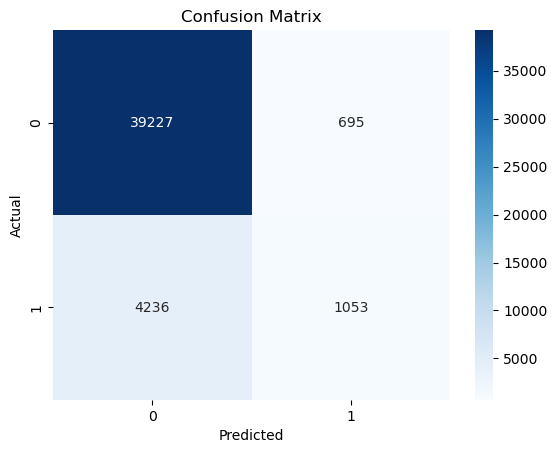

In [26]:
# new_data_corr = data_filtered.copy()
new_data_corr = new_data.copy()
data_signf=new_data_corr[best_Features]
regression_model = LogisticRegression()
Xc=data_signf.iloc[:,:-1]
yc=data_signf.iloc[:,-1]
regression_model.fit(X = Xc, y = yc)
score=regression_model.score(X = Xc, y = yc)
print("score:",score, best_Features)

# Mean Squared Error (MSE) & Root Mean Squared Error (RMSE):
predc = regression_model.predict(X=Xc)
# predictions = std2.inverse_transform(predictions.reshape(-1, 1))
mse2 = mean_squared_error(yc, predc)
rmse = np.sqrt(mse2)
print("Mean Squared Error:", mse2)
print("Root Mean Squared Error:", rmse)

# Evaluate the model

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(yc, predc))

# Confusion Matrix
conf_matrix = confusion_matrix(yc, predc)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## statsmodels

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45211
Model:                            GLM   Df Residuals:                    45194
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12086.
Date:                Tue, 05 Dec 2023   Deviance:                       24172.
Time:                        01:22:39   Pearson chi2:                 8.25e+09
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1706
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0771      0.147    -27.728      0.0

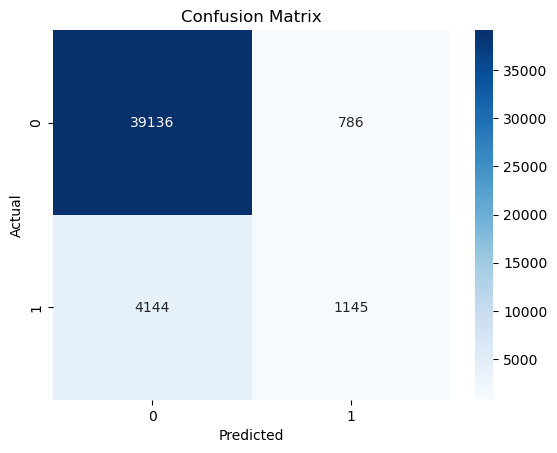

In [27]:
import statsmodels.api as sm
from sklearn.metrics import accuracy_score

X_train = sm.add_constant(X_train)  # Add a constant to the features (required for statsmodels)

logit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
result = logit_model.fit()

# Print the summary of the logistic regression model
print(result.summary())

# Make predictions on the test set
X_test = sm.add_constant(X_test)
y_pred_prob = result.predict(X_test)

# You may want to convert probabilities to binary predictions based on a threshold
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate the accuracy score
score1 = accuracy_score(y_test, y_pred)
print("Accuracy Score:", score1)

# Calculate the Mean Squared Error
mse1= mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse1)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


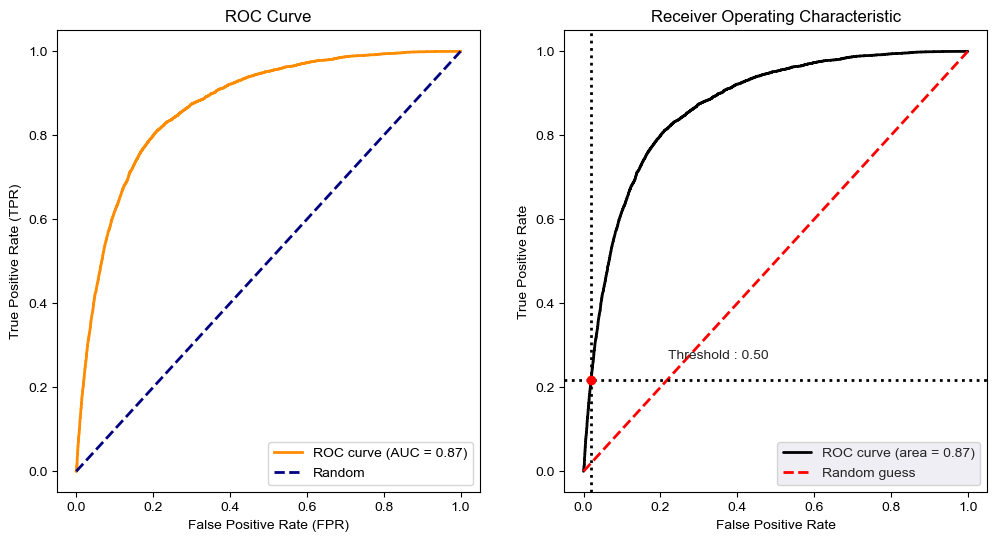

In [28]:
# Plot ROC curve using sklearn.metrics
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve using plot_metric library
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Using plot_metric library
from plot_metric.functions import BinaryClassification
plt.subplot(1, 2, 2)
bc = BinaryClassification(y_test, y_pred_prob,  labels=[0, 1])
bc.plot_roc_curve()
plt.show()

### Based on Sklearn LR  

In [29]:
model = LogisticRegression()

model.fit(X = X_train, y = y_train)

# Check trained model y-intercept
print("y-intercept:",model.intercept_)

# Check trained model coefficients
print("model coefficients:",model.coef_)

# Check model.score
score2=model.score(X = X_test, y = y_test)
print("score:",score2)

y-intercept: [-0.09061968]
model coefficients: [[-9.06145174e-02 -1.37249315e-02  2.44417317e-05 -2.15570349e-02
   3.24127322e-03 -2.79060421e-01 -8.03103861e-04  9.67617298e-02
  -9.95217826e-03 -1.10881573e-01 -1.05276026e-02 -6.39819835e-03
  -2.41280826e-01 -7.24675125e-02 -2.40633693e-01 -7.17303102e-02
  -2.13077068e-01]]
score: 0.8873725420804671


Mean Squared Error: 0.11262745791953285
Root Mean Squared Error: 0.33560014588723414

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     39922
           1       0.56      0.16      0.25      5289

    accuracy                           0.89     45211
   macro avg       0.73      0.57      0.60     45211
weighted avg       0.86      0.89      0.86     45211



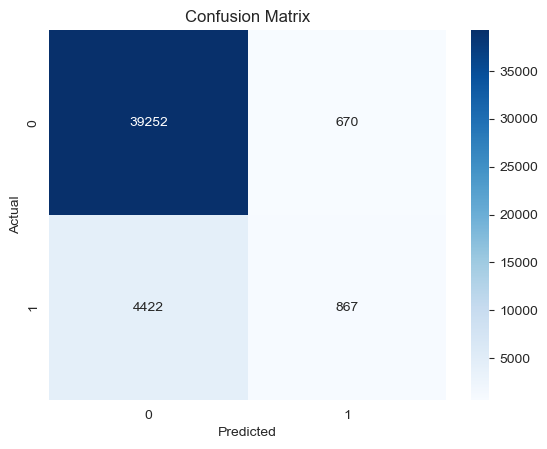

In [30]:
# Mean Squared Error (MSE) & Root Mean Squared Error (RMSE):
predictions = model.predict(X=X_test)
# predictions = std2.inverse_transform(predictions.reshape(-1, 1))
mse2 = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse2)
print("Mean Squared Error:", mse2)
print("Root Mean Squared Error:", rmse)

# Evaluate the model

from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

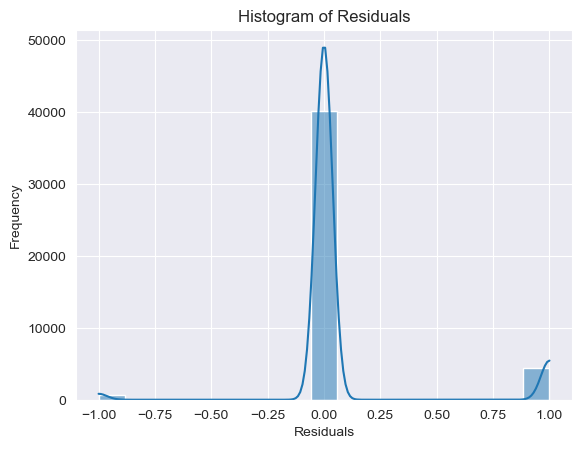

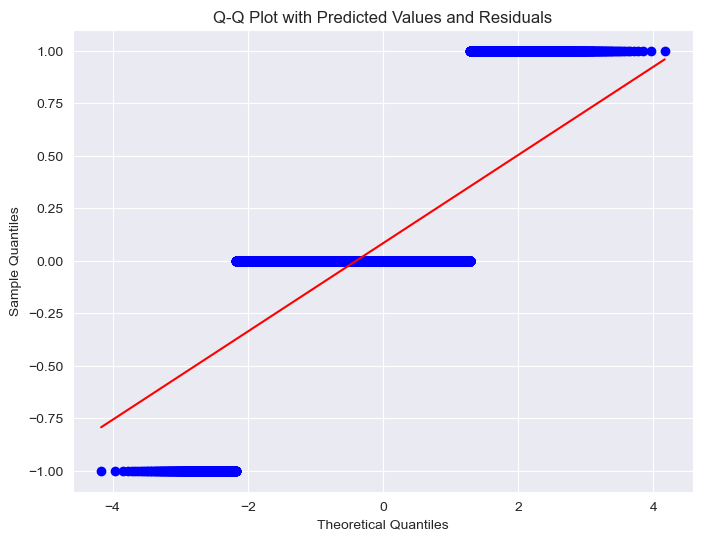

In [31]:
# Residual Analysis
pred = model.predict(X=X_train)
residuals = y - pred

# Histogram of Residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Calculate quantiles for residuals and expected quantiles for a normal distribution
residuals_quantiles = np.percentile(residuals, np.arange(0, 100, 1))
expected_quantiles = stats.norm.ppf(np.arange(0, 100, 1) / 100.0, loc=np.mean(residuals), scale=np.std(residuals))

# Create a Q-Q plot with predicted values and residuals
# pred = model.predict(X=X)
residuals = y - pred
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot with Predicted Values and Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

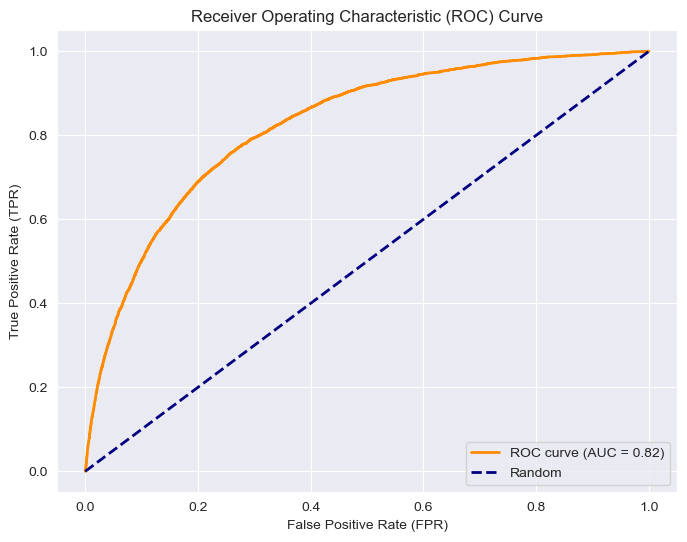

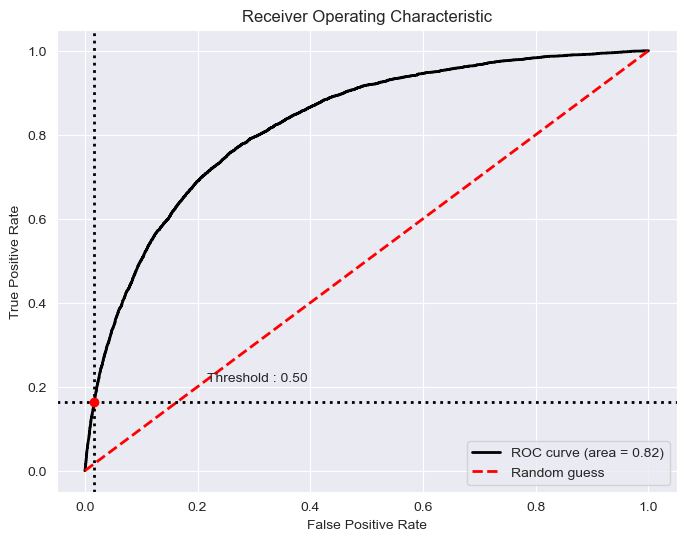

In [32]:
# ROC curve
from sklearn.metrics import roc_curve, auc
# Predict probabilities on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test, y_pred_prob,  labels=[0, 1])
plt.figure(figsize=(8, 6))
bc.plot_roc_curve()
plt.show()

### Comparing both method

In [33]:
# Compare both method score, mse
print(score1,score2)
print(mse1,mse2)

0.8909557408595253 0.8873725420804671
0.10904425914047466 0.11262745791953285


### Normalizing features

In [34]:
# CustomScaler

#withoutNormalization
class withoutNormalization:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X 
    def fit_transform(self, X, y=None):      
        self.fit(X, y)
        return self.transform(X)

#Square
class SquareScaler:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X ** 2 
    def fit_transform(self, X, y=None):      
        self.fit(X, y)
        return self.transform(X)
    
    
#Log
class LogScaler:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log(X + 1)
    def fit_transform(self, X, y=None):      
        self.fit(X, y)
        return self.transform(X)


scaler_name: without normalization


score: 0.8877934717350776
mse: 0.11360955470362726

scaler_name: Standard Scaler
score: 0.8914589060574462
mse: 0.11014450014744913

scaler_name: MinMax Scaler
score: 0.8915221032009353
mse: 0.1108817457976998

scaler_name: Square Transformation
score: 0.8864979302935507
mse: 0.11397817752875258

 best_scaler: Standard Scaler


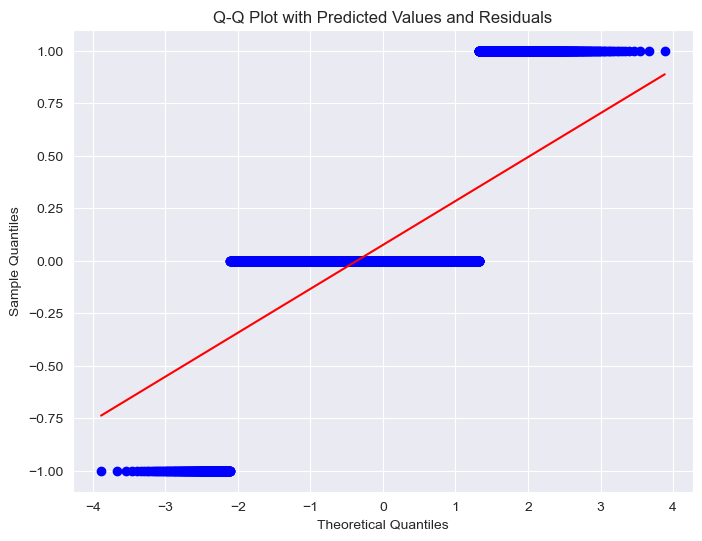

In [35]:
# Normalization to input data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

X=new_data.iloc[:,:-1]
y=new_data.iloc[:,-1]
# X_train = X
# X_test = X
# y_train= y
# y_test = y 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


results = {}

scalers = {
    'without normalization': withoutNormalization(),
    'Standard Scaler': StandardScaler(),
    'MinMax Scaler': MinMaxScaler(),
    # 'Robust Scaler': RobustScaler(),
    # 'Log Transformation2': PowerTransformer(method='box-cox'),
    'Square Transformation': SquareScaler(),
    # 'Log Transformation': LogScaler(),
}

for scaler_name, scaler in scalers.items():
    print("\nscaler_name:",scaler_name)
 
    X_train_scaled =X_train.copy()   
    X_train_scaled= scaler.fit_transform(X_train_scaled)
    
    X_test_scaled =X_test.copy()
    X_test_scaled = scaler.transform(X_test_scaled) 
    
    regression_model = LogisticRegression()
    regression_model.fit(X_train_scaled, y_train)
    
    # Check regression_model.score
    score=regression_model.score(X = X_train_scaled, 
                       y = y_train)
    print("score:",score)
    
    predictions = regression_model.predict(X_test_scaled)
    
    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test, predictions)
    print("mse:",mse)

    results[scaler_name] = {'model': regression_model, 'predictions': predictions, 'mse': mse}
    
# Choose the best model based on mse
best_scaler = min(results, key=lambda x: results[x]['mse']); print("\n best_scaler:", best_scaler)
best_model = results[best_scaler]['model']   
best_predictions = results[best_scaler]['predictions']

# Create a Q-Q plot with predicted values and residuals
residuals = y_test - best_predictions
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot with Predicted Values and Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

The best model is obtained using the ____________ normalization.  


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11966
           1       0.59      0.22      0.33      1598

    accuracy                           0.89     13564
   macro avg       0.75      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564



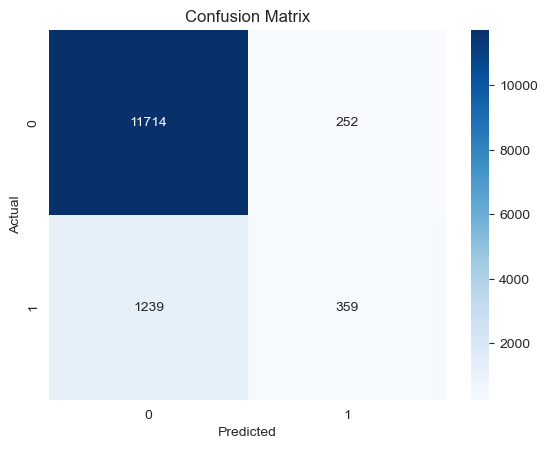

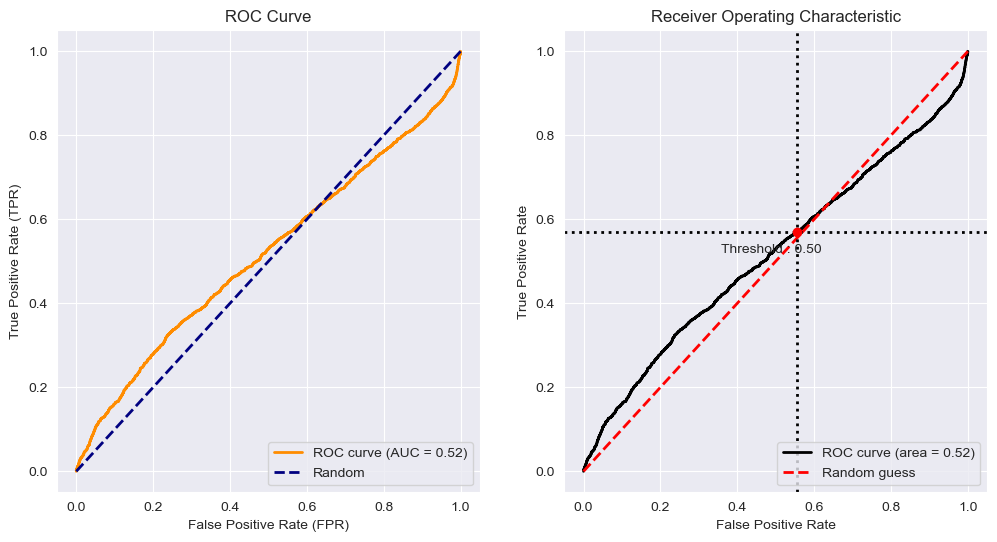

In [36]:
# Mean Squared Error (MSE) & Root Mean Squared Error (RMSE):
X_test_scaled = X_test.copy()
scaler = scalers[best_scaler]
X_test_scaled = scaler.fit_transform(X_test_scaled)
predictions = best_model.predict(X=X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Plot ROC curve using sklearn.metrics
y_pred_prob = regression_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve using plot_metric library
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Using plot_metric library
plt.subplot(1, 2, 2)
bc = BinaryClassification(y_test, y_pred_prob,  labels=[0, 1])
bc.plot_roc_curve()
plt.show()

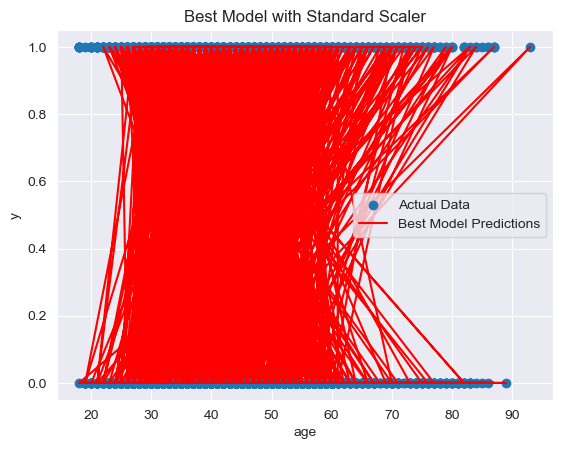

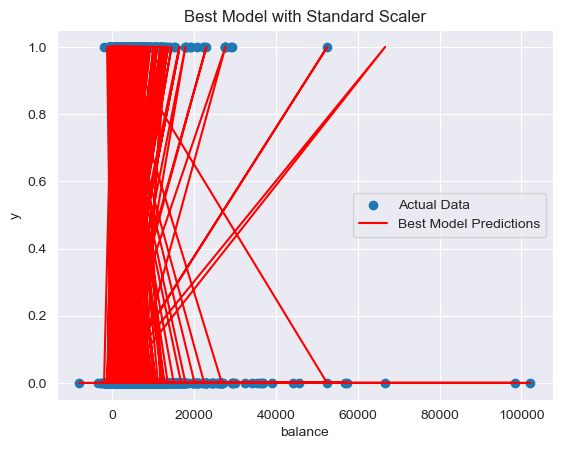

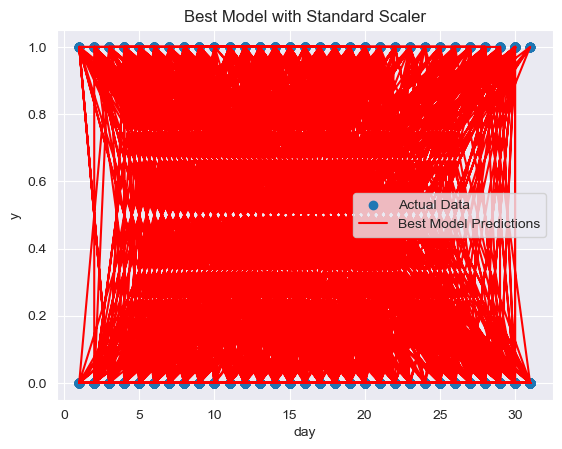

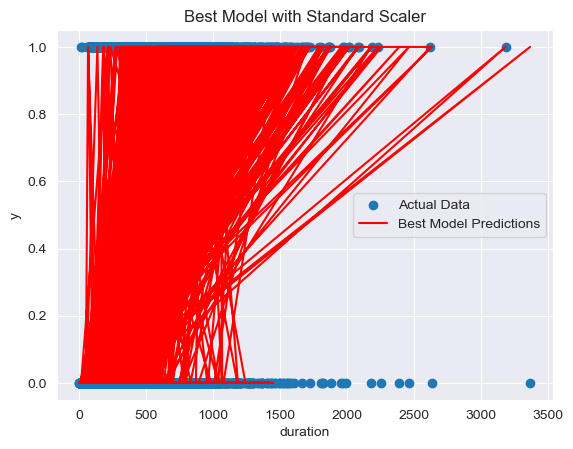

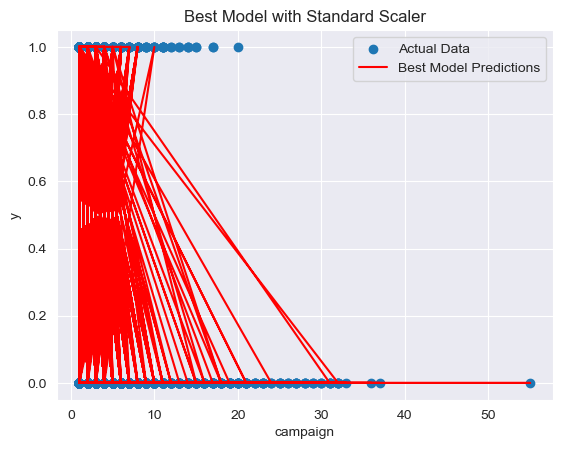

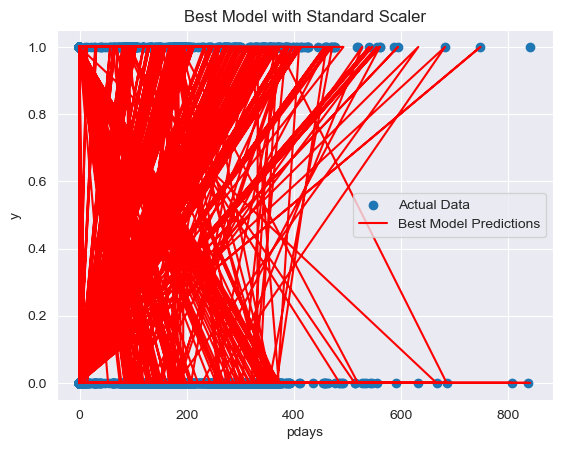

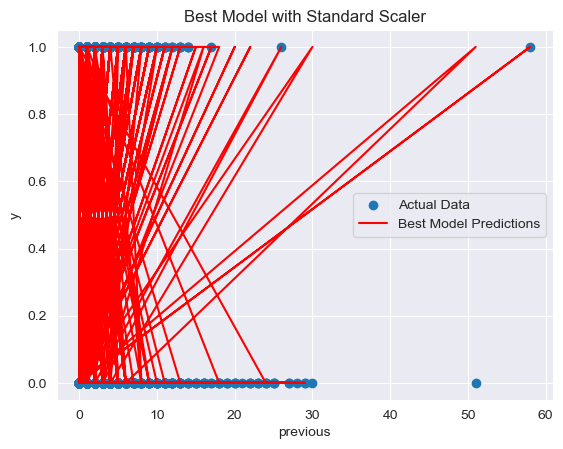

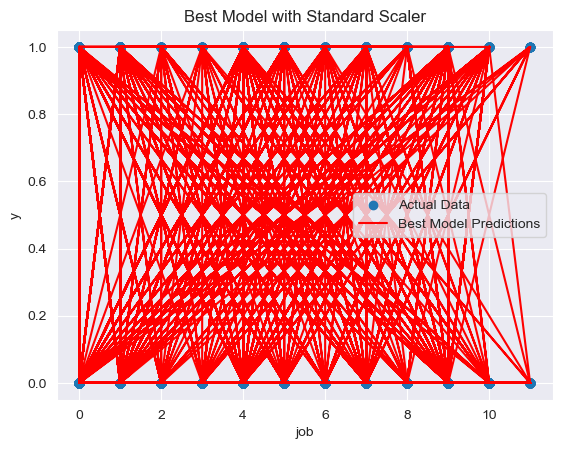

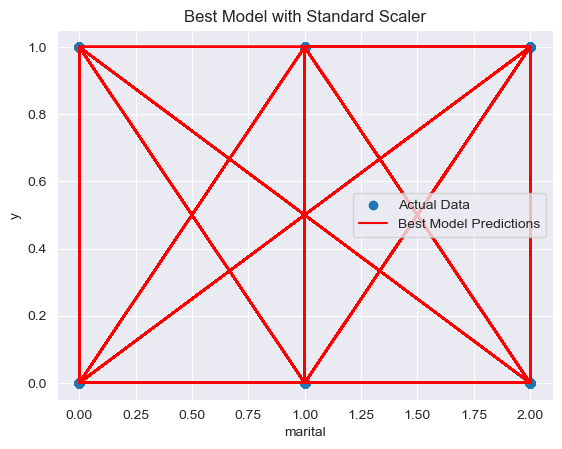

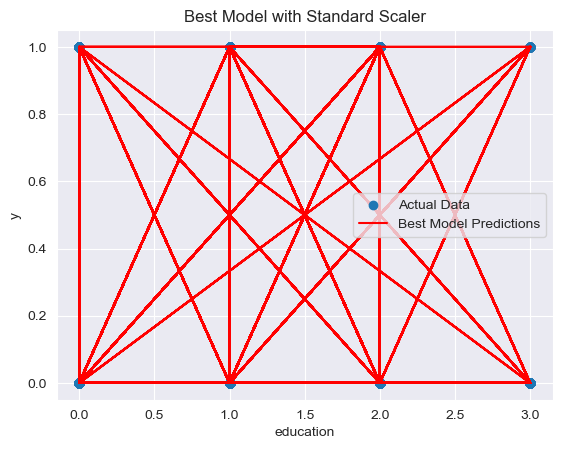

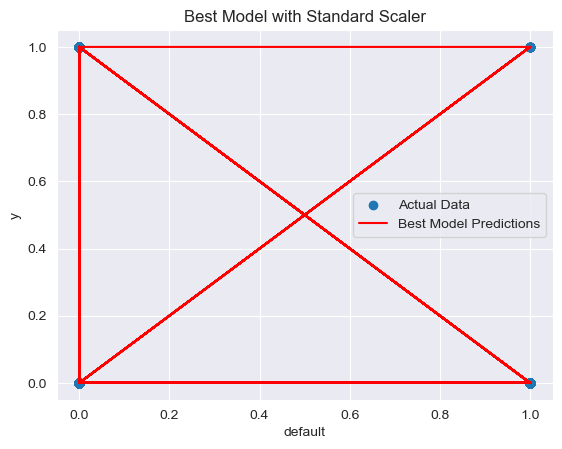

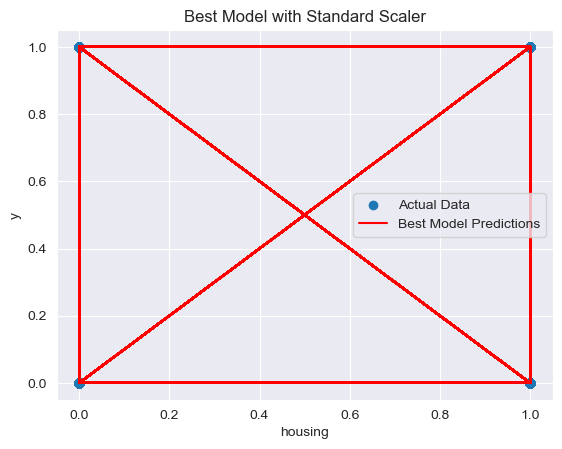

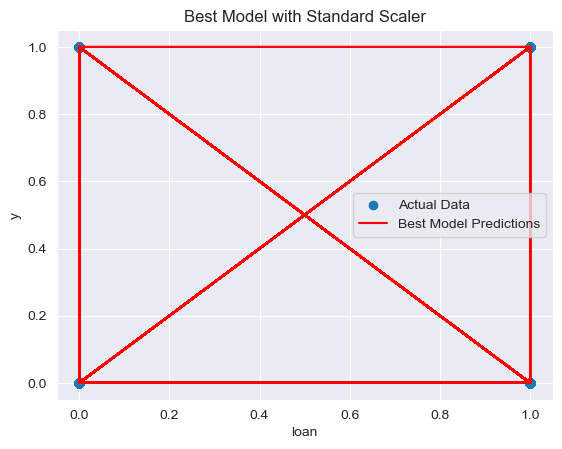

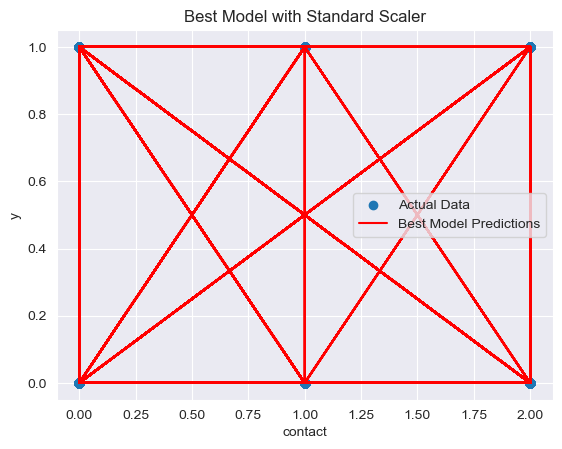

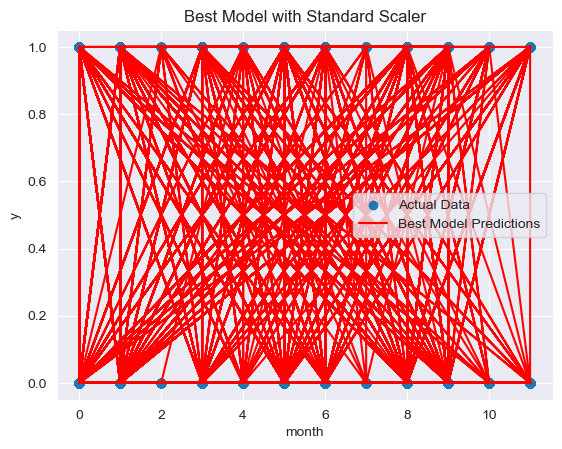

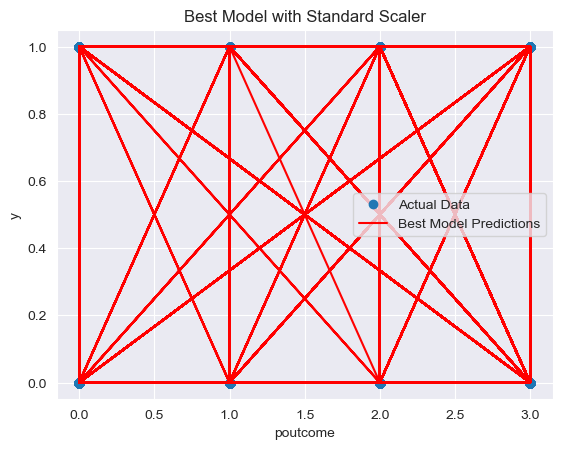

In [37]:
# Visualize the best model's predictions
for i, column in enumerate(X_test.columns):

    plt.scatter(X_test[column], y_test, label='Actual Data')
    plt.plot(X_test[column], best_predictions, label='Best Model Predictions', color='red')
    plt.xlabel(column)
    plt.ylabel('y')
    plt.legend()
    plt.title(f'Best Model with {best_scaler}')
    plt.show()

In [38]:
# Final output comparison
X_scaled = X.copy()
scaler = scalers[best_scaler]
X_scaled = scaler.fit_transform(X_scaled)
predictions_new = best_model.predict(X_scaled)
new_data2=new_data.copy()
new_data2['Price_pred']=pd.DataFrame(predictions_new,columns=['Price'])

new_data2.tail()

age  balance  day  duration  campaign  pdays  previous  job  marital  \
45206   51      825   17       977         3     -1         0    9        1   
45207   71     1729   17       456         2     -1         0    5        0   
45208   72     5715   17      1127         5    184         3    5        1   
45209   57      668   17       508         4     -1         0    1        1   
45210   37     2971   17       361         2    188        11    2        1   

       education  default  housing  loan  contact  month  poutcome  y  \
45206          2        0        0     0        0      9         3  1   
45207          0        0        0     0        0      9         3  1   
45208          1        0        0     0        0      9         2  1   
45209          1        0        0     0        1      9         3  0   
45210          1        0        0     0        0      9         1  0   

       Price_pred  
45206           1  
45207           0  
45208           1  
45209           0  
45210           1

## Model Predictions

In [39]:
# New Data
X_new = new_data.iloc[0:10,:-1]
X_new1 = X_new.copy()
X_new1.reset_index(drop=True, inplace=True)

X_scaled = X_new.copy()
scaler = scalers[best_scaler]
X_scaled = scaler.fit_transform(X_new) 
predictions_new = best_model.predict(X_scaled)
predictions_new=pd.DataFrame(predictions_new,columns=['y'])

predicted = pd.concat([X_new1,predictions_new],axis=1)
predicted

age  balance  day  duration  campaign  pdays  previous  job  marital  \
0   58     2143    5       261         1     -1         0    4        1   
1   44       29    5       151         1     -1         0    9        2   
2   33        2    5        76         1     -1         0    2        1   
3   47     1506    5        92         1     -1         0    1        1   
4   33        1    5       198         1     -1         0   11        2   
5   35      231    5       139         1     -1         0    4        1   
6   28      447    5       217         1     -1         0    4        2   
7   42        2    5       380         1     -1         0    2        0   
8   58      121    5        50         1     -1         0    5        1   
9   43      593    5        55         1     -1         0    9        2   

   education  default  housing  loan  contact  month  poutcome  y  
0          2        0        1     0        2      8         3  0  
1          1        0        1     0        2      8         3  0  
2          1        0        1     1        2      8         3  0  
3          3        0        1     0        2      8         3  0  
4          3        0        0     0        2      8         3  0  
5          2        0        1     0        2      8         3  0  
6          2        0        1     1        2      8         3  0  
7          2        1        1     0        2      8         3  0  
8          0        0        1     0        2      8         3  0  
9          1        0        1     0        2      8         3  0